## Fraud Prediction

### Load Libraries
    * Libraries for data preparation
    * Fast ML Libraries for data imputation and encoding
        - for installing fast-ml use command "pip install fast-ml" in command prompt
    * sklearn libraries for modelling, confusion matrix and prediction
    

In [1]:
#Import os, pandas and numpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from lightgbm import LGBMClassifier
import datetime

In [2]:
from fast_ml.eda import categorical_plots,numerical_plots
from fast_ml.missing_data_analysis import MissingDataAnalysis
from fast_ml.missing_data_imputation import MissingDataImputer_Categorical, MissingDataImputer_Numerical
from fast_ml.utilities import rare_encoding
from fast_ml.feature_engineering import FeatureEngineering_Categorical,FeatureEngineering_Numerical
from fast_ml.utilities import reduce_memory_usage
from fast_ml.eda import categorical_plots,numerical_plots,categorical_plots_with_target,numerical_plots_with_target,numerical_bins_with_target


In [6]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

#### Functions

* "compare_Numerical_distribution" function to compare distribution of numerical data before and after imputation
* "clustercheck" to check if the set of variables belong to the same cluster.
* "Browser_transform","OS_transform" and "Mail_transform" to normalize the observation in variables,

In [7]:

def compare_Numerical_distribution(df1,df2,variables):
    df = pd.DataFrame()
    msg_value = []
    data = []
    for a in variables:
        df_mean = df1[a].mean() - df2[a].mean()
        df_std = df1[a].std() - df2[a].std()
        if int(df_mean) == 0:
            msg_mean = "Mean of both the dataset is same" #+ str(df1[a].mean()) + str(df2[a].mean()) 
        else:
            msg_mean = "Mean of both the dataset differ by " + str(df_mean)
        if int(df_std) == 0:
            msg_std = "Standard Dev. of both the dataset is same"
        else:
            msg_std = "Standard Dev the dataset differ by " + str(df_std) 
            
        if int(df_mean) == 0 and int(df_std) ==0:
            msg_Remark = "Distribution for dataset is same"
            
        else:
            msg_Remark = "Distribution for dataset is different"
            
        msg_value = [a,msg_mean,msg_std,msg_Remark] 
        zipped  = zip(["Variable","Mean","Stdev","Remark"],msg_value)
        a_dict = dict(zipped)
        data.append(a_dict)
    df= df.append(data,True)
    return(df)


def clustercheck(df,base,cluster):
    nullcount = df[base].isnull().sum()
    LiTrue = []
    LiFalse = []
    for a in cluster:
        if df[a].isnull().sum() == nullcount:
            LiTrue.append(a)
        else:
            LiFalse.append(a)

    print("List of elements having same missing value is", LiTrue)
    print("List of elements having different missing value is", LiFalse)
    
def Browser_transform(df,col):
    df.loc[df[col].str.contains('chrome', na=False), col] = 'Chrome'
    df.loc[df[col].str.contains('firefox', na=False), col] = 'Firefox'
    df.loc[df[col].str.contains('safari', na=False), col] = 'Safari'
    df.loc[df[col].str.contains('edge', na=False), col] = 'Edge'
    df.loc[df[col].str.contains('ie', na=False), col] = 'IE'
    df.loc[df[col].str.contains('samsung', na=False), col] = 'Samsung'
    df.loc[df[col].str.contains('opera', na=False), col] = 'Opera'
    #df.loc[df[col].str.contains('Others', na=False), col] = 'other'
    df[col].fillna("Missing", inplace=True)
    df.loc[df.id_31.isin(df.id_31.value_counts()[df.id_31.value_counts() < 200].index), col] = "other"
    
def OS_transform(df,col):
    df.loc[df[col].str.contains('Windows', na=False), col] = 'Windows'
    df.loc[df[col].str.contains('iOS', na=False), col] = 'iOS'
    df.loc[df[col].str.contains('Mac OS', na=False), col] = 'Mac'
    df.loc[df[col].str.contains('Android', na=False), col] = 'Android'
    df[col].fillna("Missing", inplace=True)
    
def Mail_transform(df,col):
    df.loc[df[col].str.contains('gmail', na=False), col] = 'gmail.com'
    df.loc[df[col].str.contains('yahoo', na=False), col] = 'yahoo.com'
    df.loc[df[col].str.contains('outlook', na=False), col] = 'outlook.com'
    df.loc[df[col].str.contains('hotmail', na=False), col] = 'hotmail.com'
    df[col].fillna("Missing", inplace=True)
    
def Remove_dup(x):
    return list(dict.fromkeys(x))

    #return df   


### Import Data

In [8]:
n = 590540 #number of records in file
s = 50000 #desired sample size
filename = "D:\\Kaggle\\Fraud_Detection\\train_transaction.csv"
skip = sorted(random.sample(range(n),n-s))
train = pd.read_csv(filename, skiprows=skip[1:])
#train_transaction =  pd.read_csv("")
#train_identity = pd.read_csv("D:\\Kaggle\\Fraud_Detection\\train_identity.csv")
#train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [13]:
train = reduce_memory_usage(train, convert_to_category=False)

Memory usage of dataframe is 44.11 MB
Memory usage after optimization is: 44.11 MB
Decreased by 0.0%


## Test Train Split

* Create Test, Train and Validate DataSet

In [14]:
y = train['isFraud']
x_train = train.drop('isFraud', axis =1)
from sklearn.model_selection import train_test_split
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y, test_size=0.2, random_state=0)
#from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [15]:
#from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [19]:
x_train.shape,y_train.shape

((32000, 393), (32000,))

In [20]:
X_test.shape,y_test.shape

((8000, 393), (8000,))

In [21]:
x_valid.shape,y_valid.shape

((10001, 393), (10001,))

#####  Identify variables Based on EDA performed

In [26]:
Rare_2 =['P_emaildomain']
Rare_4 =['R_emaildomain']
#'D5' : [0,30,40,50,60,70,80,90,100],
Custom_Bin ={
'TransactionAmt' : [0,10,20,40,50,60,70,90,100],
'C1' : [0,50,70,80,90,100],
'C2' : [0,50,70,80,90,100],
'C4' : [0,70,90,100],
'C5' : [0,60,80,90,100],
'C6' : [0,60,80,90,100],
'C7' : [0,80,90,100],
'C8' : [0,70,90,100],
'C9' : [0,60,80,90,100],
'C10' : [0,70,90,100],
'C11' : [0,60,80,90,100],
'C12' : [0,80,90,100],
'C13' : [0,10,50,60,70,80,90,100],
'C14' : [0,80,90,100],
'D1' : [0,50,60,70,80,90,100],
'addr1' : [0,90,100],
'D10' : [0,50,60,70,80,90,100],
'D15' : [0,30,40,50,60,70,80,90,100],
'D4' : [0,10,50,60,70,80,90,100],
'D3' : [0,30,40,50,60,100],
'D2' : [0,10,20,30,40,50,60,70,100],
'D11' : [0,40,50,60,70,80,90,100],
'D6' : [0,70,80,90,100],
'D12' : [0,70,80,90,100],
'D14' : [0,70,80,90,100],
'D13' : [0,90,100],
'D7' : [0,60,90,100],'V330': [0, 90, 100],'V329': [0, 90, 100],'V326': [0, 90, 100],'V334': [0, 98, 100],
'V337': [0, 95, 100],'V339': [0, 90, 100],	'V336': [0, 95, 100],	'V338': [0, 90, 100],	'V322': [0, 95, 100],
             'V324': [0, 80, 100],	'V323': [0, 90, 100],	'V335': [0, 90, 100],	'V331': [0, 90, 100],
             'V333': [0, 80, 100],	'V332': [0, 80, 100],	'V311': [0, 98, 100],	'V319': [0, 98, 100],
             'V321': [0, 95, 100],	'V309': [0, 95, 100],	'V320': [0, 95, 100],	'V316': [0, 95, 100],
             'V313': [0, 90, 100],	'V318': [0, 95, 100],	'V315': [0, 90, 100],	'V312': [0, 80, 90, 100],
             'V317': [0, 90, 100],	'V306': [0, 90, 100],	'V314': [0, 90, 100],	'V308': [0, 80, 100],
             'V310': [0, 70, 80, 90, 100],'V307': [0, 60, 80, 100]}



In [27]:
Adaptive_10p = ['card1' ,'card3','card5' ,'card2' ,'dist1' ,'D8','dist2','V225',	'V193',	'V190',	'V170',	'V237',
                'V176',	'V192',	'V199',	'V261',	'V171',	'V243',	'V254',	'V236',	'V246',	'V255',	'V256',	'V257',	'V227',
                'V299',	'V151',	'V182',	'V228',	'V201',	'V245',	'V290',	'V283',	'V144',	'V180',	'V230',	'V253',	'V258',
                'V259',	'V222',	'V221',	'V224',	'V226',	'V229',	'V296',	'V298',	'V285',	'V187',	'V234',	'V269',	'V292',	
                'V291',	'V145',	'V177',	'V167',	'V143',	'V179',	'V168',	'V178',	'V231',	'V217',	'V233',	'V232',	'V219',
                'V218',	'V166',	'V164',	'V129',	'V293',	'V279',	'V295',	'V165',	'V280',	'V150',	'V135',	'V294',	'V137',
                'V206',	'V159',	'V136',	'V266',	'V131',	'V205',	'V132',	'V270',	'V160',	'V272',	'V208',	'V210',	'V276',
                'V214',	'V268',	'V271',	'V278',	'V134',	'V216',	'V277',	'V209',	'V207',	'V215',	'V267',	'V126',	'V133',
                'V128',	'V273',	'V275',	'V130',	'V211',	'V127',	'V274',	'V213',	'V212',	'V263',	'V202',	'V265',	'V204',
                'V264',	'V203']
Adaptive_5p = ['V200',	'V106',	'V105',	'V161',	'V163',	'V162',	'V101',	'V103',	'V102']


In [28]:
Rare_5 = ['ProductCD',	'card4',	'card6',	'addr2',	'M6',	'M1',	'M2',	'M3',	'M4',	'M7',	'M8',	'M9',	'M5',	'D9',
'V9',	'V8',	'V5',	'V4',	'V3',	'V2',	'V11',	'V10',	'V50',	'V49',	'V48',	'V42',	'V41',	'V40',	'V36',	'V35',	'V94',	'V93',
          'V92',	'V91',	'V90',	'V89',	'V88',	'V87',	'V86',	'V85',	'V84',	'V83',	'V82',	'V81',	'V80',	'V79',	'V77',	'V74',	'V73',
          'V72',	'V71',	'V70',	'V69',	'V68',	'V67',	'V65',	'V64',	'V63',	'V62',	'V60',	'V59',	'V58',	'V57',	'V55',	'V53',	'V34',
          'V33',	'V32',	'V31',	'V30',	'V29',	'V28',	'V27',	'V26',	'V25',	'V24',	'V22',	'V21',	'V19',	'V18',	'V17',	'V16',	'V15',
          'V14',	'V13',	'V12',	'V98','V141',	'V173',	'V325',	'V142',	'V174',	'V194',	'V197',	'V301',	'V153',	'V302',	'V304',	'V148',	'V154',
          'V155',	'V157',	'V175',	'V184',	'V123',	'V195',	'V303',	'V138',	'V328',	'V146',	'V156',	'V327',	'V158',	'V198',	'V147',	'V185',	'V181',
          'V169',	'V188']
Rare_10 = ['V107',	'V117',	'V118',	'V119',	'V120',	'V121',	'V122',	'V108',	'V109',	'V110',	'V111',	'V112',	'V113',	'V114',	'V115',	'V116',	'V124',
           'V125',	'V104']


In [29]:
# Variable to drop
Var_to_Drop = ['C3','TransactionID','TransactionDT']

##### Drop unwanted Variables

In [30]:
x_train = x_train.drop(Var_to_Drop,axis=1)
x_valid = x_valid.drop(Var_to_Drop,axis=1)

##### Feature engineering to string variables

In [31]:
#Browser_transform(x_train,'id_31')
#OS_transform(x_train,'id_30')
Mail_transform(x_train,'P_emaildomain')
Mail_transform(x_train,'R_emaildomain')

#Browser_transform(x_valid,'id_31')
#OS_transform(x_valid,'id_30')
Mail_transform(x_valid,'P_emaildomain')
Mail_transform(x_valid,'R_emaildomain')

### Rare Encoding

In [32]:
rare_encoder2 = FeatureEngineering_Categorical( method='rare')
rare_encoder2.fit(x_train, Rare_2, target=None, rare_tol=2)
x_train = rare_encoder2.transform(x_train)
x_valid = rare_encoder2.transform(x_valid)

In [38]:
rare_encoder3 = FeatureEngineering_Categorical( method='rare')
rare_encoder3.fit(x_train, Rare_4, target=None, rare_tol=4)
x_train = rare_encoder3.transform(x_train)
x_valid = rare_encoder3.transform(x_valid)

In [39]:
rare_encoder4 = FeatureEngineering_Categorical( method='rare')
rare_encoder4.fit(x_train, Rare_5, target=None, rare_tol=5)
x_train = rare_encoder4.transform(x_train)
x_valid = rare_encoder4.transform(x_valid)

In [40]:
rare_encoder5 = FeatureEngineering_Categorical( method='rare')
rare_encoder5.fit(x_train, Rare_10, target=None, rare_tol=10)
x_train = rare_encoder5.transform(x_train)
x_valid = rare_encoder5.transform(x_valid)

In [162]:
len(rare_encoder.param_dict_)

19

### Binning

In [41]:
### ADAPTIVE 10 PERCENTILE BINNING 

from fast_ml.feature_engineering import FeatureEngineering_Numerical
num_binner = FeatureEngineering_Numerical(method = '10p', adaptive = True)
num_binner.fit(x_train, Adaptive_10p)
x_train = num_binner.transform(x_train)
x_valid = num_binner.transform(x_valid)

[1007.0, 2803.0, 4921.0, 6951.0, 8135.0, 9749.0, 11467.0, 12934.999999999993, 15124.0, 16632.0, 18395.0]
[-inf, 2803.0, 4921.0, 6951.0, 8135.0, 9749.0, 11467.0, 12934.999999999993, 15124.0, 16632.0, inf]
[100.0, 150.0, 185.0, 229.0]
[-inf, 150.0, 185.0, inf]
[100.0, 126.0, 166.0, 195.0, 224.0, 226.0, 236.0]
[-inf, 126.0, 166.0, 195.0, 224.0, 226.0, inf]
[100.0, 111.0, 194.0, 264.0, 321.0, 361.0, 445.0, 490.0, 543.0, 555.0, 600.0]
[-inf, 111.0, 194.0, 264.0, 321.0, 361.0, 445.0, 490.0, 543.0, 555.0, inf]
[0.0, 1.0, 2.0, 4.0, 6.0, 8.0, 12.0, 18.0, 35.0, 266.39999999999964, 4964.0]
[-inf, 1.0, 2.0, 4.0, 6.0, 8.0, 12.0, 18.0, 35.0, 266.39999999999964, inf]
[0.0, 0.58349609375, 0.83349609375, 3.041015625, 16.125, 41.71875, 85.0, 148.625, 243.875, 452.0, 1544.0]
[-inf, 0.58349609375, 0.83349609375, 3.041015625, 16.125, 41.71875, 85.0, 148.625, 243.875, 452.0, inf]
[0.0, 1.0, 7.0, 13.0, 32.0, 76.0, 156.5999999999999, 286.0, 619.6000000000001, 5888.0]
[-inf, 1.0, 7.0, 13.0, 32.0, 76.0, 156.599

In [42]:
### ADAPTIVE 5 PERCENTILE BINNING 
num_binner2 = FeatureEngineering_Numerical(method = '5p', adaptive = True)
num_binner2.fit(x_train, Adaptive_5p)
x_train = num_binner2.transform(x_train)
x_valid = num_binner2.transform(x_valid)

[0.0, 1.0, 2.0, 35.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 49.0]
[-inf, 1.0, inf]
[0.0, 1.0, 77.0]
[-inf, 1.0, inf]
[0.0, 3000.0]
[-inf, inf]
[0.0, 3000.0]
[-inf, inf]
[0.0, 3000.0]
[-inf, inf]
[0.0, 1.0, 846.0]
[-inf, 1.0, inf]
[0.0, 1.0, 892.0]
[-inf, 1.0, inf]
[0.0, 1.0, 1228.0]
[-inf, 1.0, inf]


In [43]:
for key, value in Custom_Bin.items():
    num_bin_custom = FeatureEngineering_Numerical(method = 'custom', adaptive = False, custom_buckets= value)
    num_bin_custom.fit(x_train,[key])
    print(key,value)
    x_train = num_bin_custom.transform(x_train)
    x_valid = num_bin_custom.transform(x_valid)

[0.467041015625, 26.0609375, 35.9375, 57.9375, 70.0, 100.0, 117.0, 280.0, 31936.0]
[-inf, 26.0609375, 35.9375, 57.9375, 70.0, 100.0, 117.0, 280.0, inf]
TransactionAmt [0, 10, 20, 40, 50, 60, 70, 90, 100]
[0.0, 1.0, 2.0, 3.0, 6.0, 4632.0]
[-inf, 1.0, 2.0, 3.0, 6.0, inf]
C1 [0, 50, 70, 80, 90, 100]
[0.0, 1.0, 2.0, 3.0, 7.0, 5416.0]
[-inf, 1.0, 2.0, 3.0, 7.0, inf]
C2 [0, 50, 70, 80, 90, 100]
[0.0, 0.0, 1.0, 2220.0]
[-inf, 0.0, 1.0, inf]
C4 [0, 70, 90, 100]
[0.0, 0.0, 1.0, 3.0, 324.0]
[-inf, 0.0, 1.0, 3.0, inf]
C5 [0, 60, 80, 90, 100]
[0.0, 1.0, 2.0, 5.0, 2220.0]
[-inf, 1.0, 2.0, 5.0, inf]
C6 [0, 60, 80, 90, 100]
[0.0, 0.0, 1.0, 2220.0]
[-inf, 0.0, 1.0, inf]
C7 [0, 80, 90, 100]
[0.0, 0.0, 1.0, 3260.0]
[-inf, 0.0, 1.0, inf]
C8 [0, 70, 90, 100]
[0.0, 1.0, 2.0, 4.0, 194.0]
[-inf, 1.0, 2.0, 4.0, inf]
C9 [0, 60, 80, 90, 100]
[0.0, 0.0, 1.0, 3182.0]
[-inf, 0.0, 1.0, inf]
C10 [0, 70, 90, 100]
[0.0, 1.0, 2.0, 4.0, 3132.0]
[-inf, 1.0, 2.0, 4.0, inf]
C11 [0, 60, 80, 90, 100]
[0.0, 0.0, 1.0, 3132.0]


In [44]:
cat_imputer = MissingDataImputer_Categorical(method = 'custom_value',add_indicator=False,value = 'Missing')
cat_imputer.fit(x_train, variables = Rare_5)
x_train = cat_imputer.transform(x_train)
x_valid = cat_imputer.transform(x_valid)

cat_imputer2 = MissingDataImputer_Categorical(method = 'custom_value',add_indicator=False,value = 'Missing')
cat_imputer2.fit(x_train, variables = Rare_10)
x_train = cat_imputer2.transform(x_train)
x_valid = cat_imputer2.transform(x_valid)

In [46]:
licol = x_train.columns
mda_obj = MissingDataAnalysis(x_train[licol], target='isfraud', model = 'Classification' )
X_miss = mda_obj.calculate_missing_values()
x_missvar = X_miss.variables
catcol =[]
numcol = []
for col in x_missvar:
    if len(x_train[col].unique()) <=20 :
        catcol.append(col)
    else:
        numcol.append(col)
#catcol.extend(["id_31","id_33","DeviceInfo"])
#numcol.remove("id_33")
#numcol.remove("DeviceInfo")
rare_encoder1 = FeatureEngineering_Categorical( method='rare')
rare_encoder1.fit(x_train, catcol, target=None, rare_tol=5)
x_train = rare_encoder1.transform(x_train)
x_valid = rare_encoder1.transform(x_valid)

num_binner3 = FeatureEngineering_Numerical(method = '5p', adaptive = True)
num_binner3.fit(x_train, numcol)
x_train = num_binner3.transform(x_train)
x_valid = num_binner3.transform(x_valid)


[0.0, 1.0, 2.0, 4.0, 29.0]
[-inf, 1.0, 2.0, 4.0, inf]
[1.0, 2.0, 64.0, 68.0, 69.0]
[-inf, 2.0, 64.0, 68.0, inf]
[0.0, 1.0, 38.0]
[-inf, 1.0, inf]
[1.0, 2.0, 37.0]
[-inf, 2.0, inf]
[0.0, 1.0, 29.0]
[-inf, 1.0, inf]
[1.0, 37.0]
[-inf, inf]
[0.0, 1.0, 2.0, 25.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 13.0, 15.0, 21.0, 27.0, 33.0, 46.0, 68.0, 113.0, 237.0, 729.0]
[-inf, 1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 13.0, 15.0, 21.0, 27.0, 33.0, 46.0, 68.0, 113.0, 237.0, inf]
[0.0, 1.0, 2.0, 31.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 32.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 31.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 31.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 25.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 23.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 3.0, 4.0, 86.0]
[-inf, 1.0, 2.0, 3.0, 4.0, inf]
[0.0, 1.0, 857.0]
[-inf, 1.0, inf]
[0.0, 1.0, 2.0, 3.0, 6.0, 1332.0]
[-inf, 1.0, 2.0, 3.0, 6.0, inf]
[0.0, 1.0, 3.0, 936.0]
[-inf, 1.0, 3.0, inf]
[0.0, 1.0, 2.0, 31.0]
[-inf, 1.0, 2.0, inf]


In [ ]:
#x_train['variable'].head()

### Label Encoding -  Avoid Label Encoding Just RUN One Hot

In [47]:
label_encoder = FeatureEngineering_Categorical( method='label')
label_encoder.fit(x_train,variables= Rare_5)
x_train= label_encoder.transform(x_train)
x_valid = label_encoder.transform(x_valid)

In [170]:
label_encoder2 = FeatureEngineering_Categorical( method='label')
label_encoder2.fit(x_train,variables= Rare_10)
x_train= label_encoder2.transform(x_train)
x_valid = label_encoder2.transform(x_valid)

In [171]:
label_encoder3 = FeatureEngineering_Categorical( method='label')
label_encoder3.fit(x_train,variables= Rare_10)
x_train= label_encoder3.transform(x_train)
x_valid = label_encoder3.transform(x_valid)

In [172]:
label_encoder4 = FeatureEngineering_Categorical( method='label')
label_encoder4.fit(x_train,variables= catcol)
x_train= label_encoder4.transform(x_train)
x_valid = label_encoder4.transform(x_valid)

In [173]:
#label_encoder4 = FeatureEngineering_Categorical( method='label')
label_encoder4.fit(x_train,variables= Adaptive_10p)
x_train= label_encoder4.transform(x_train)
x_valid = label_encoder4.transform(x_valid)

In [175]:
label_encoder5 = FeatureEngineering_Categorical( method='label')
label_encoder5.fit(x_train,variables= Adaptive_5p)
x_train= label_encoder5.transform(x_train)
x_valid = label_encoder5.transform(x_valid)

In [176]:
label_encoder6 = FeatureEngineering_Categorical( method='label')
label_encoder6.fit(x_train,variables= numcol)
x_train= label_encoder6.transform(x_train)
x_valid = label_encoder6.transform(x_valid)

In [49]:
listcolumn= ['TransactionAmt','addr1','P_emaildomain','R_emaildomain','C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D6','D7','D10','D11','D12','D13','D14','D15','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317','V318','V319','V320','V321','V322','V323','V324','V326','V329','V330','V331','V332','V333','V334','V335','V336','V337','V338','V339']

In [180]:
label_encoder7 = FeatureEngineering_Categorical( method='label')
label_encoder7.fit(x_train,variables= listcolumn)
x_train= label_encoder7.transform(x_train)
x_valid = label_encoder7.transform(x_valid)

### One Hot

In [ ]:
Onehot_Encode = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode.fit(x_train,variables= Rare_5)
x_train= Onehot_Encode.transform(x_train)
x_valid = Onehot_Encode.transform(x_valid)

In [56]:
Onehot_Encode2 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode2.fit(x_train,variables= Rare_10)
x_train= Onehot_Encode2.transform(x_train)
x_valid = Onehot_Encode2.transform(x_valid)

In [59]:
Onehot_Encode4 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode4.fit(x_train,variables= catcol)
x_train= Onehot_Encode4.transform(x_train)
x_valid = Onehot_Encode4.transform(x_valid)

In [60]:
#Onehot_Encode4 = FeatureEngineering_Categorical( method='Onehot')
Onehot_Encode4.fit(x_train,variables= Adaptive_10p)
x_train= Onehot_Encode4.transform(x_train)
x_valid = Onehot_Encode4.transform(x_valid)

In [61]:
Onehot_Encode5 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode5.fit(x_train,variables= Adaptive_5p)
x_train= Onehot_Encode5.transform(x_train)
x_valid = Onehot_Encode5.transform(x_valid)

In [62]:
Onehot_Encode6 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode6.fit(x_train,variables= numcol)
x_train= Onehot_Encode6.transform(x_train)
x_valid = Onehot_Encode6.transform(x_valid)

In [ ]:
listcolumn= ['TransactionAmt','addr1','P_emaildomain','R_emaildomain','C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D6','D7','D10','D11','D12','D13','D14','D15','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317','V318','V319','V320','V321','V322','V323','V324','V326','V329','V330','V331','V332','V333','V334','V335','V336','V337','V338','V339']

In [63]:
Onehot_Encode7 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode7.fit(x_train,variables= listcolumn)
x_train= Onehot_Encode7.transform(x_train)
x_valid = Onehot_Encode7.transform(x_valid)

In [64]:
DF_Analysis= pd.DataFrame(x_train.dtypes)
DF_Analysis.index.name = "Variable"
DF_Analysis.columns = ["DType"]
DF_Analysis["Unique"] = x_train.nunique()
DF_Analysis["Missing_Count"]=pd.DataFrame(x_train.isnull().sum())
DF_Analysis["Missing_Rate"] = round((x_train.isnull().sum()/x_train.shape[0])*100,2)

DF_Analysis["Cat_Num"] = np.where(DF_Analysis.Unique >=60,"Numerical",(np.where(DF_Analysis.DType == "object",
                                                                     "Categorical","Num_Cat")))
DF_Analysis.sort_values(by = ["Missing_Count"], ascending= False)
DF_Analysis["Imputation_Method"] = np.where(DF_Analysis.Missing_Rate >0,
                                            np.where(DF_Analysis.Cat_Num == "Categorical","Missing",
                                            np.where(DF_Analysis.Cat_Num == "Num_Cat","Missing","Binning")),"Not Applicable")
    #np.where(DF_Analysis.Missing_Rate ==0,"Not Applicable",np.where(DF_Analysis.Cat_Num == "Categorical","Mode",
   # np.where(DF_Analysis.Cat_Num == "Num_Cat","Mode","Mean_Median"))))
DF_Analysis["Drop_Variable"] =  np.where(DF_Analysis.Missing_Rate >=90, "Yes","No")

In [65]:
DF_Analysis.sort_values(by = 'Unique',ascending=False).head(100)

,DType,Unique,Missing_Count,Missing_Rate,Cat_Num,Imputation_Method,Drop_Variable
Variable,,,,,,,
TransactionDT,int32,31941,0,0.0,Numerical,Not Applicable,No
"V275_(-inf, 61.344]",int32,2,0,0.0,Num_Cat,Not Applicable,No
V130_Missing,int32,2,0,0.0,Num_Cat,Not Applicable,No
"V130_(235.975, inf]",int32,2,0,0.0,Num_Cat,Not Applicable,No
"V130_(29.0, 107.938]",int32,2,0,0.0,Num_Cat,Not Applicable,No
...,...,...,...,...,...,...,...
V183_Missing,int32,2,0,0.0,Num_Cat,Not Applicable,No
"V101_(1.0, inf]",int32,2,0,0.0,Num_Cat,Not Applicable,No
"V183_(1.0, inf]",int32,2,0,0.0,Num_Cat,Not Applicable,No


In [78]:
#DF_Analysis[DF_Analysis["Cat_Num"] == 'Numerical']

### Normalizing Column names

In [92]:
litraincolOrg = x_train.columns
litraincol  =  litraincolOrg
livalidcolOrg = x_valid.columns
livalidcol  =  livalidcolOrg

In [93]:
import re
[str(sentence).replace("' "," ") for sentence in litraincol]
[str(sentence).replace("' "," ") for sentence in livalidcol]

['TransactionDT',
 'ProductCD_0',
 'ProductCD_1',
 'ProductCD_2',
 'ProductCD_3',
 'ProductCD_4',
 'card4_0',
 'card4_1',
 'card4_2',
 'card6_0',
 'card6_1',
 'card6_2',
 'addr2_0',
 'addr2_1',
 'M6_0',
 'M6_1',
 'M6_2',
 'M1_0',
 'M1_1',
 'M2_0',
 'M2_1',
 'M2_2',
 'M3_0',
 'M3_1',
 'M3_2',
 'M4_0',
 'M4_1',
 'M4_2',
 'M4_3',
 'M7_0',
 'M7_1',
 'M7_2',
 'M8_0',
 'M8_1',
 'M8_2',
 'M9_0',
 'M9_1',
 'M9_2',
 'M5_0',
 'M5_1',
 'M5_2',
 'D9_0',
 'V9_0',
 'V9_1',
 'V8_0',
 'V8_1',
 'V5_0',
 'V5_1',
 'V5_2',
 'V4_0',
 'V4_1',
 'V4_2',
 'V3_0',
 'V3_1',
 'V2_0',
 'V2_1',
 'V11_0',
 'V11_1',
 'V11_2',
 'V10_0',
 'V10_1',
 'V10_2',
 'V50_0',
 'V50_1',
 'V50_2',
 'V49_0',
 'V49_1',
 'V49_2',
 'V48_0',
 'V48_1',
 'V48_2',
 'V42_0',
 'V42_1',
 'V42_2',
 'V41_0',
 'V41_1',
 'V40_0',
 'V40_1',
 'V40_2',
 'V36_0',
 'V36_1',
 'V36_2',
 'V35_0',
 'V35_1',
 'V35_2',
 'V94_0',
 'V94_1',
 'V94_2',
 'V93_0',
 'V93_1',
 'V93_2',
 'V92_0',
 'V92_1',
 'V92_2',
 'V91_0',
 'V91_1',
 'V91_2',
 'V90_0',
 'V90_1'

In [73]:
for a in ["-","."," ","(","]"]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [94]:
for a in ["_0_","__","_0,"]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [74]:
for a in [","]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [95]:
x_train.columns = litraincol
x_valid.columns = livalidcol
    

#### Modelling

In [172]:
model5 = LGBMClassifier()
model5.fit(x_train, y_train)


LGBMClassifier()

In [259]:
x_train.columns

Index(['ProductCD_0', 'ProductCD_1', 'ProductCD_2', 'ProductCD_3',
       'ProductCD_4', 'card4_0', 'card4_1', 'card4_2', 'card6_0', 'card6_1',
       ...
       'V336_100__inf_', 'V337__inf__200_', 'V337_Missing', 'V337_200__inf_',
       'V338__inf__50_', 'V338_Missing', 'V338_50__inf_', 'V339__inf__35_',
       'V339_Missing', 'V339_35__inf_'],
      dtype='object', length=1222)

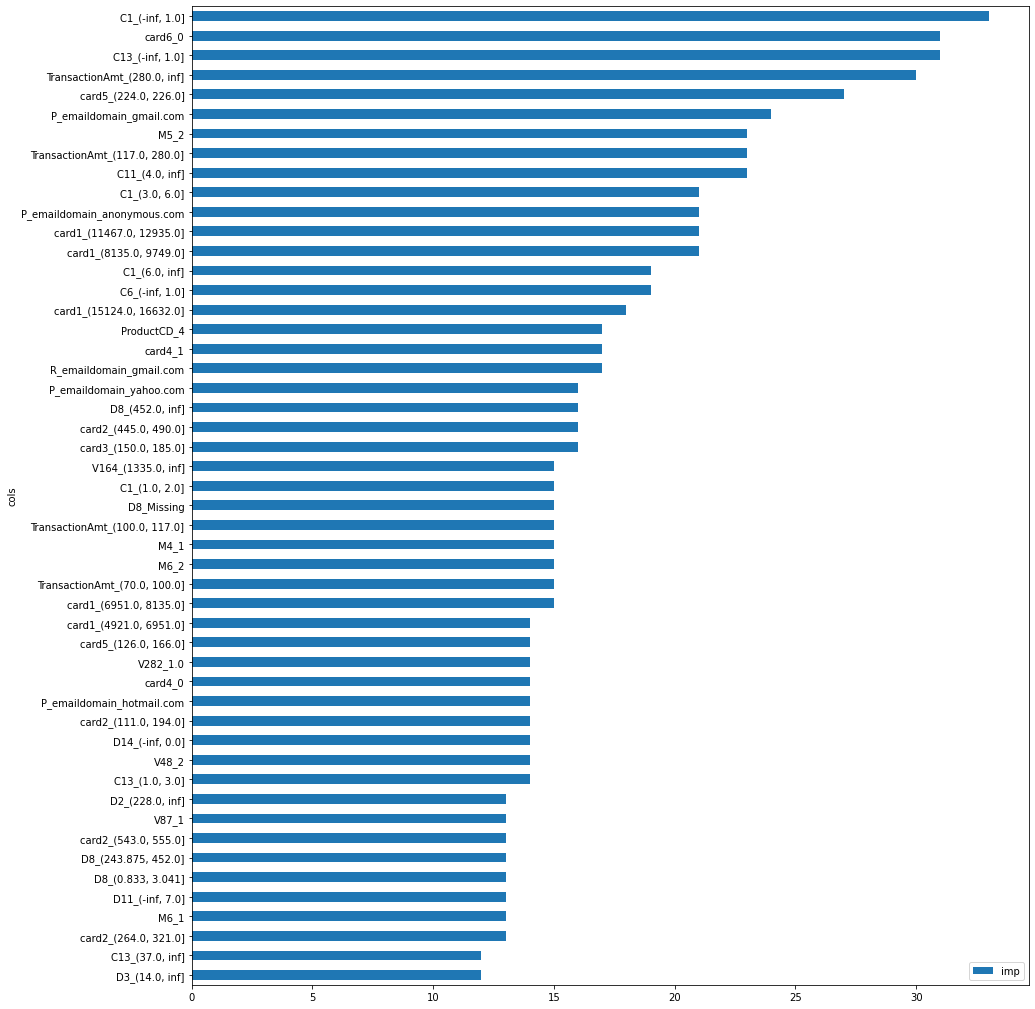

In [213]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model5.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

In [174]:
predicted = model5.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

Confusion Matrix :
[[9634   23]
 [ 232  112]]
Accuracy Score : 0.9745025497450255
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9657
           1       0.83      0.33      0.47       344

    accuracy                           0.97     10001
   macro avg       0.90      0.66      0.73     10001
weighted avg       0.97      0.97      0.97     10001



### Using Optuna

In [87]:
import optuna.integration.lightgbm as lgb

In [158]:
dtrain = lgb.Dataset(x_train, label=y_train)
dval = lgb.Dataset(x_valid, label=y_valid)

In [159]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

model = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100)

[I 2020-09-15 22:49:58,942] A new study created in memory with name: no-name-b4590528-ae91-42d1-b82e-b0f65e052084



  0%|                                                    | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                  | 0/7 [00:01<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0523114	valid_1's binary_logloss: 0.0901961
[200]	training's binary_logloss: 0.0349862	valid_1's binary_logloss: 0.0897997
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0362217	valid_1's binary_logloss: 0.089393





feature_fraction, val_score: 0.089393:   0%|             | 0/7 [01:41<?, ?it/s]


feature_fraction, val_score: 0.089393:  14%|5   | 1/7 [01:41<10:07, 101.33s/it][I 2020-09-15 22:51:44,348] Trial 0 finished with value: 0.08939299053689721 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.08939299053689721.



feature_fraction, val_score: 0.089393:  14%|5   | 1/7 [01:41<10:07, 101.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0510591	valid_1's binary_logloss: 0.0900227
[200]	training's binary_logloss: 0.0323199	valid_1's binary_logloss: 0.0905071
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0492248	valid_1's binary_logloss: 0.089894





feature_fraction, val_score: 0.089393:  14%|5   | 1/7 [01:50<10:07, 101.33s/it]


feature_fraction, val_score: 0.089393:  29%|#4   | 2/7 [01:50<06:08, 73.66s/it][I 2020-09-15 22:51:53,422] Trial 1 finished with value: 0.08989395065914015 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.08939299053689721.



feature_fraction, val_score: 0.089393:  29%|#4   | 2/7 [01:50<06:08, 73.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0522626	valid_1's binary_logloss: 0.0903024
[200]	training's binary_logloss: 0.0347046	valid_1's binary_logloss: 0.0890083
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0355686	valid_1's binary_logloss: 0.088899





feature_fraction, val_score: 0.088899:  29%|#4   | 2/7 [02:01<06:08, 73.66s/it]


feature_fraction, val_score: 0.088899:  43%|##1  | 3/7 [02:01<03:38, 54.75s/it][I 2020-09-15 22:52:03,806] Trial 2 finished with value: 0.08889895255437336 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.08889895255437336.



feature_fraction, val_score: 0.088899:  43%|##1  | 3/7 [02:01<03:38, 54.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





feature_fraction, val_score: 0.087414:  43%|##1  | 3/7 [02:11<03:38, 54.75s/it]


feature_fraction, val_score: 0.087414:  57%|##8  | 4/7 [02:11<02:04, 41.56s/it][I 2020-09-15 22:52:14,611] Trial 3 finished with value: 0.08741361883365037 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.08741361883365037.



feature_fraction, val_score: 0.087414:  57%|##8  | 4/7 [02:11<02:04, 41.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0537425	valid_1's binary_logloss: 0.0900071
[200]	training's binary_logloss: 0.0360924	valid_1's binary_logloss: 0.0891362
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0426508	valid_1's binary_logloss: 0.0888423





feature_fraction, val_score: 0.087414:  57%|##8  | 4/7 [02:21<02:04, 41.56s/it]


feature_fraction, val_score: 0.087414:  71%|###5 | 5/7 [02:21<01:03, 31.85s/it][I 2020-09-15 22:52:23,798] Trial 4 finished with value: 0.08884226256685838 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.08741361883365037.



feature_fraction, val_score: 0.087414:  71%|###5 | 5/7 [02:21<01:03, 31.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050197	valid_1's binary_logloss: 0.0898831
[200]	training's binary_logloss: 0.0320511	valid_1's binary_logloss: 0.0902852
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0466093	valid_1's binary_logloss: 0.0897472





feature_fraction, val_score: 0.087414:  71%|###5 | 5/7 [02:29<01:03, 31.85s/it]


feature_fraction, val_score: 0.087414:  86%|####2| 6/7 [02:29<00:24, 24.77s/it][I 2020-09-15 22:52:32,041] Trial 5 finished with value: 0.0897472213078895 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.08741361883365037.



feature_fraction, val_score: 0.087414:  86%|####2| 6/7 [02:29<00:24, 24.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0514156	valid_1's binary_logloss: 0.089539
[200]	training's binary_logloss: 0.0334528	valid_1's binary_logloss: 0.0894224
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0429458	valid_1's binary_logloss: 0.0889227





feature_fraction, val_score: 0.087414:  86%|####2| 6/7 [02:38<00:24, 24.77s/it]


feature_fraction, val_score: 0.087414: 100%|#####| 7/7 [02:39<00:00, 22.75s/it]



  0%|                                                   | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 0.087414:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0242183	valid_1's binary_logloss: 0.0915162
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0321639	valid_1's binary_logloss: 0.0901896





num_leaves, val_score: 0.087414:   0%|                  | 0/20 [00:10<?, ?it/s]


num_leaves, val_score: 0.087414:   5%|5         | 1/20 [00:10<03:19, 10.48s/it][I 2020-09-15 22:52:52,559] Trial 7 finished with value: 0.09018955283712059 and parameters: {'num_leaves': 78}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:   5%|5         | 1/20 [00:10<03:19, 10.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.113903	valid_1's binary_logloss: 0.112634
[200]	training's binary_logloss: 0.109723	valid_1's binary_logloss: 0.108884
[300]	training's binary_logloss: 0.107219	valid_1's binary_logloss: 0.106642
[400]	training's binary_logloss: 0.10548	valid_1's binary_logloss: 0.105109
[500]	training's binary_logloss: 0.104179	valid_1's binary_logloss: 0.103998
[600]	training's binary_logloss: 0.103156	valid_1's binary_logloss: 0.1033
[700]	training's binary_logloss: 0.102322	valid_1's binary_logloss: 0.102759
[800]	training's binary_logloss: 0.101628	valid_1's binary_logloss: 0.102287
[900]	training's binary_logloss: 0.101036	valid_1's binary_logloss: 0.101932
[1000]	training's binary_logloss: 0.100521	valid_1's binary_logloss: 0.10162
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.100521	valid_1's binary_logloss: 0.10162





num_leaves, val_score: 0.087414:   5%|5         | 1/20 [00:32<03:19, 10.48s/it]


num_leaves, val_score: 0.087414:  10%|#         | 2/20 [00:32<04:10, 13.92s/it][I 2020-09-15 22:53:14,733] Trial 8 finished with value: 0.10162047836583452 and parameters: {'num_leaves': 2}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:  10%|#         | 2/20 [00:32<04:10, 13.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00566669	valid_1's binary_logloss: 0.10883
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0277593	valid_1's binary_logloss: 0.0924082





num_leaves, val_score: 0.087414:  10%|#         | 2/20 [00:47<04:10, 13.92s/it]


num_leaves, val_score: 0.087414:  15%|#5        | 3/20 [00:47<04:00, 14.14s/it][I 2020-09-15 22:53:29,125] Trial 9 finished with value: 0.09240817675610405 and parameters: {'num_leaves': 197}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:  15%|#5        | 3/20 [00:47<04:00, 14.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00335257	valid_1's binary_logloss: 0.11861
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0298859	valid_1's binary_logloss: 0.0936877





num_leaves, val_score: 0.087414:  15%|#5        | 3/20 [01:07<04:00, 14.14s/it]


num_leaves, val_score: 0.087414:  20%|##        | 4/20 [01:07<04:14, 15.88s/it][I 2020-09-15 22:53:49,095] Trial 10 finished with value: 0.0936876561804365 and parameters: {'num_leaves': 251}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:  20%|##        | 4/20 [01:07<04:14, 15.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0158624	valid_1's binary_logloss: 0.0951015
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0342767	valid_1's binary_logloss: 0.0911507





num_leaves, val_score: 0.087414:  20%|##        | 4/20 [01:17<04:14, 15.88s/it]


num_leaves, val_score: 0.087414:  25%|##5       | 5/20 [01:17<03:34, 14.32s/it][I 2020-09-15 22:53:59,776] Trial 11 finished with value: 0.09115073861425986 and parameters: {'num_leaves': 108}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:  25%|##5       | 5/20 [01:17<03:34, 14.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.09246	valid_1's binary_logloss: 0.0979508
[200]	training's binary_logloss: 0.0821459	valid_1's binary_logloss: 0.0936608
[300]	training's binary_logloss: 0.0748209	valid_1's binary_logloss: 0.0926707
[400]	training's binary_logloss: 0.0688019	valid_1's binary_logloss: 0.0917064
[500]	training's binary_logloss: 0.0634449	valid_1's binary_logloss: 0.091152
[600]	training's binary_logloss: 0.0589607	valid_1's binary_logloss: 0.0911729
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.0604284	valid_1's binary_logloss: 0.0910095





num_leaves, val_score: 0.087414:  25%|##5       | 5/20 [01:35<03:34, 14.32s/it]


num_leaves, val_score: 0.087414:  30%|###       | 6/20 [01:35<03:33, 15.25s/it][I 2020-09-15 22:54:17,192] Trial 12 finished with value: 0.09100951869248204 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:  30%|###       | 6/20 [01:35<03:33, 15.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00636875	valid_1's binary_logloss: 0.106516
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0260951	valid_1's binary_logloss: 0.0924722





num_leaves, val_score: 0.087414:  30%|###       | 6/20 [01:48<03:33, 15.25s/it]


num_leaves, val_score: 0.087414:  35%|###5      | 7/20 [01:48<03:10, 14.69s/it][I 2020-09-15 22:54:30,572] Trial 13 finished with value: 0.09247224118417981 and parameters: {'num_leaves': 190}. Best is trial 7 with value: 0.09018955283712059.



num_leaves, val_score: 0.087414:  35%|###5      | 7/20 [01:48<03:10, 14.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0327289	valid_1's binary_logloss: 0.090197
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0356326	valid_1's binary_logloss: 0.0898194





num_leaves, val_score: 0.087414:  35%|###5      | 7/20 [01:57<03:10, 14.69s/it]


num_leaves, val_score: 0.087414:  40%|####      | 8/20 [01:57<02:36, 13.04s/it][I 2020-09-15 22:54:39,756] Trial 14 finished with value: 0.08981937273275506 and parameters: {'num_leaves': 56}. Best is trial 14 with value: 0.08981937273275506.



num_leaves, val_score: 0.087414:  40%|####      | 8/20 [01:57<02:36, 13.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00323346	valid_1's binary_logloss: 0.118516
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0317491	valid_1's binary_logloss: 0.0926224





num_leaves, val_score: 0.087414:  40%|####      | 8/20 [02:14<02:36, 13.04s/it]


num_leaves, val_score: 0.087414:  45%|####5     | 9/20 [02:14<02:36, 14.27s/it][I 2020-09-15 22:54:56,880] Trial 15 finished with value: 0.09262243860573753 and parameters: {'num_leaves': 254}. Best is trial 14 with value: 0.08981937273275506.



num_leaves, val_score: 0.087414:  45%|####5     | 9/20 [02:14<02:36, 14.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00686706	valid_1's binary_logloss: 0.105747
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0300583	valid_1's binary_logloss: 0.0930983





num_leaves, val_score: 0.087414:  45%|####5     | 9/20 [02:27<02:36, 14.27s/it]


num_leaves, val_score: 0.087414:  50%|####5    | 10/20 [02:27<02:16, 13.68s/it][I 2020-09-15 22:55:09,196] Trial 16 finished with value: 0.09309829320946024 and parameters: {'num_leaves': 179}. Best is trial 14 with value: 0.08981937273275506.



num_leaves, val_score: 0.087414:  50%|####5    | 10/20 [02:27<02:16, 13.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0100488	valid_1's binary_logloss: 0.101699
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0291197	valid_1's binary_logloss: 0.0925394





num_leaves, val_score: 0.087414:  50%|####5    | 10/20 [02:38<02:16, 13.68s/it]


num_leaves, val_score: 0.087414:  55%|####9    | 11/20 [02:38<01:58, 13.12s/it][I 2020-09-15 22:55:21,006] Trial 17 finished with value: 0.09253944945668965 and parameters: {'num_leaves': 145}. Best is trial 14 with value: 0.08981937273275506.



num_leaves, val_score: 0.087414:  55%|####9    | 11/20 [02:38<01:58, 13.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0399751	valid_1's binary_logloss: 0.08971
[200]	training's binary_logloss: 0.0225046	valid_1's binary_logloss: 0.0918522
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0365214	valid_1's binary_logloss: 0.0895628





num_leaves, val_score: 0.087414:  55%|####9    | 11/20 [02:48<01:58, 13.12s/it]


num_leaves, val_score: 0.087414:  60%|#####3   | 12/20 [02:48<01:35, 11.92s/it][I 2020-09-15 22:55:30,121] Trial 18 finished with value: 0.089562827010829 and parameters: {'num_leaves': 44}. Best is trial 18 with value: 0.089562827010829.



num_leaves, val_score: 0.087414:  60%|#####3   | 12/20 [02:48<01:35, 11.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00434912	valid_1's binary_logloss: 0.113232
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0346488	valid_1's binary_logloss: 0.0923778





num_leaves, val_score: 0.087414:  60%|#####3   | 12/20 [03:01<01:35, 11.92s/it]


num_leaves, val_score: 0.087414:  65%|#####8   | 13/20 [03:01<01:25, 12.28s/it][I 2020-09-15 22:55:43,233] Trial 19 finished with value: 0.09237782958836434 and parameters: {'num_leaves': 223}. Best is trial 18 with value: 0.089562827010829.



num_leaves, val_score: 0.087414:  65%|#####8   | 13/20 [03:01<01:25, 12.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0111638	valid_1's binary_logloss: 0.0996477
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0313784	valid_1's binary_logloss: 0.0912816





num_leaves, val_score: 0.087414:  65%|#####8   | 13/20 [03:12<01:25, 12.28s/it]


num_leaves, val_score: 0.087414:  70%|######3  | 14/20 [03:12<01:12, 12.04s/it][I 2020-09-15 22:55:54,736] Trial 20 finished with value: 0.09128163140333075 and parameters: {'num_leaves': 137}. Best is trial 18 with value: 0.089562827010829.



num_leaves, val_score: 0.087414:  70%|######3  | 14/20 [03:12<01:12, 12.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0168448	valid_1's binary_logloss: 0.0931671
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0276995	valid_1's binary_logloss: 0.0899353





num_leaves, val_score: 0.087414:  70%|######3  | 14/20 [03:22<01:12, 12.04s/it]


num_leaves, val_score: 0.087414:  75%|######7  | 15/20 [03:22<00:57, 11.48s/it][I 2020-09-15 22:56:04,895] Trial 21 finished with value: 0.08993534648484286 and parameters: {'num_leaves': 104}. Best is trial 18 with value: 0.089562827010829.



num_leaves, val_score: 0.087414:  75%|######7  | 15/20 [03:22<00:57, 11.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0491499	valid_1's binary_logloss: 0.0899266
[200]	training's binary_logloss: 0.0311448	valid_1's binary_logloss: 0.0901326
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0419481	valid_1's binary_logloss: 0.0894546





num_leaves, val_score: 0.087414:  75%|######7  | 15/20 [03:32<00:57, 11.48s/it]


num_leaves, val_score: 0.087414:  80%|#######2 | 16/20 [03:32<00:43, 10.85s/it][I 2020-09-15 22:56:14,273] Trial 22 finished with value: 0.08945457769721304 and parameters: {'num_leaves': 32}. Best is trial 22 with value: 0.08945457769721304.



num_leaves, val_score: 0.087414:  80%|#######2 | 16/20 [03:32<00:43, 10.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00857069	valid_1's binary_logloss: 0.101948
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0296972	valid_1's binary_logloss: 0.0920103





num_leaves, val_score: 0.087414:  80%|#######2 | 16/20 [03:44<00:43, 10.85s/it]


num_leaves, val_score: 0.087414:  85%|#######6 | 17/20 [03:44<00:33, 11.15s/it][I 2020-09-15 22:56:26,125] Trial 23 finished with value: 0.09201034089970635 and parameters: {'num_leaves': 159}. Best is trial 22 with value: 0.08945457769721304.



num_leaves, val_score: 0.087414:  85%|#######6 | 17/20 [03:44<00:33, 11.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00488638	valid_1's binary_logloss: 0.112097
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0290956	valid_1's binary_logloss: 0.0932473





num_leaves, val_score: 0.087414:  85%|#######6 | 17/20 [03:57<00:33, 11.15s/it]


num_leaves, val_score: 0.087414:  90%|########1| 18/20 [03:57<00:23, 11.79s/it][I 2020-09-15 22:56:39,391] Trial 24 finished with value: 0.09324734239708152 and parameters: {'num_leaves': 213}. Best is trial 22 with value: 0.08945457769721304.



num_leaves, val_score: 0.087414:  90%|########1| 18/20 [03:57<00:23, 11.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0160458	valid_1's binary_logloss: 0.0955514
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0336052	valid_1's binary_logloss: 0.0906454





num_leaves, val_score: 0.087414:  90%|########1| 18/20 [04:06<00:23, 11.79s/it]


num_leaves, val_score: 0.087414:  95%|########5| 19/20 [04:06<00:11, 11.05s/it][I 2020-09-15 22:56:48,740] Trial 25 finished with value: 0.09064541513936362 and parameters: {'num_leaves': 106}. Best is trial 22 with value: 0.08945457769721304.



num_leaves, val_score: 0.087414:  95%|########5| 19/20 [04:06<00:11, 11.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00414494	valid_1's binary_logloss: 0.115479
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.0292183	valid_1's binary_logloss: 0.0929278





num_leaves, val_score: 0.087414:  95%|########5| 19/20 [04:21<00:11, 11.05s/it]


num_leaves, val_score: 0.087414: 100%|#########| 20/20 [04:21<00:00, 13.07s/it]



  0%|                                                   | 0/10 [00:00<?, ?it/s]


bagging, val_score: 0.087414:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0493668	valid_1's binary_logloss: 0.090778
[200]	training's binary_logloss: 0.0308508	valid_1's binary_logloss: 0.091481
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0457696	valid_1's binary_logloss: 0.0902854





bagging, val_score: 0.087414:   0%|                     | 0/10 [00:08<?, ?it/s]


bagging, val_score: 0.087414:  10%|#3           | 1/10 [00:08<01:17,  8.59s/it][I 2020-09-15 22:57:12,111] Trial 27 finished with value: 0.09028541621413518 and parameters: {'bagging_fraction': 0.8091665172457336, 'bagging_freq': 5}. Best is trial 27 with value: 0.09028541621413518.



bagging, val_score: 0.087414:  10%|#3           | 1/10 [00:08<01:17,  8.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0498457	valid_1's binary_logloss: 0.0937768
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0503852	valid_1's binary_logloss: 0.0936898





bagging, val_score: 0.087414:  10%|#3           | 1/10 [00:14<01:17,  8.59s/it]


bagging, val_score: 0.087414:  20%|##6          | 2/10 [00:14<01:01,  7.67s/it][I 2020-09-15 22:57:17,649] Trial 28 finished with value: 0.09368984483602225 and parameters: {'bagging_fraction': 0.40499166793039615, 'bagging_freq': 1}. Best is trial 27 with value: 0.09028541621413518.



bagging, val_score: 0.087414:  20%|##6          | 2/10 [00:14<01:01,  7.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0517551	valid_1's binary_logloss: 0.0946129
[200]	training's binary_logloss: 0.0319708	valid_1's binary_logloss: 0.0969384
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0509646	valid_1's binary_logloss: 0.0944865





bagging, val_score: 0.087414:  20%|##6          | 2/10 [00:19<01:01,  7.67s/it]


bagging, val_score: 0.087414:  30%|###9         | 3/10 [00:19<00:47,  6.85s/it][I 2020-09-15 22:57:22,593] Trial 29 finished with value: 0.09448654435052649 and parameters: {'bagging_fraction': 0.4396284039222349, 'bagging_freq': 7}. Best is trial 27 with value: 0.09028541621413518.



bagging, val_score: 0.087414:  30%|###9         | 3/10 [00:19<00:47,  6.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0496081	valid_1's binary_logloss: 0.0892317
[200]	training's binary_logloss: 0.0309975	valid_1's binary_logloss: 0.0894534
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.040667	valid_1's binary_logloss: 0.0885506





bagging, val_score: 0.087414:  30%|###9         | 3/10 [00:31<00:47,  6.85s/it]


bagging, val_score: 0.087414:  40%|#####2       | 4/10 [00:31<00:51,  8.56s/it][I 2020-09-15 22:57:35,132] Trial 30 finished with value: 0.08855055925609986 and parameters: {'bagging_fraction': 0.9543235609186052, 'bagging_freq': 1}. Best is trial 30 with value: 0.08855055925609986.



bagging, val_score: 0.087414:  40%|#####2       | 4/10 [00:31<00:51,  8.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.049752	valid_1's binary_logloss: 0.0895245
[200]	training's binary_logloss: 0.0313899	valid_1's binary_logloss: 0.0888988
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.040312	valid_1's binary_logloss: 0.0884317





bagging, val_score: 0.087414:  40%|#####2       | 4/10 [00:44<00:51,  8.56s/it]


bagging, val_score: 0.087414:  50%|######5      | 5/10 [00:44<00:49,  9.85s/it][I 2020-09-15 22:57:47,986] Trial 31 finished with value: 0.08843167106621365 and parameters: {'bagging_fraction': 0.9829436336798887, 'bagging_freq': 1}. Best is trial 31 with value: 0.08843167106621365.



bagging, val_score: 0.087414:  50%|######5      | 5/10 [00:44<00:49,  9.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0497818	valid_1's binary_logloss: 0.0894889
[200]	training's binary_logloss: 0.0316695	valid_1's binary_logloss: 0.0890926
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0332134	valid_1's binary_logloss: 0.0889251





bagging, val_score: 0.087414:  50%|######5      | 5/10 [00:59<00:49,  9.85s/it]


bagging, val_score: 0.087414:  60%|#######8     | 6/10 [00:59<00:45, 11.41s/it][I 2020-09-15 22:58:03,043] Trial 32 finished with value: 0.08892509383099555 and parameters: {'bagging_fraction': 0.9883783399880949, 'bagging_freq': 1}. Best is trial 31 with value: 0.08843167106621365.



bagging, val_score: 0.087414:  60%|#######8     | 6/10 [00:59<00:45, 11.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0503058	valid_1's binary_logloss: 0.0899747
[200]	training's binary_logloss: 0.0321755	valid_1's binary_logloss: 0.0895649
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0393185	valid_1's binary_logloss: 0.0891223





bagging, val_score: 0.087414:  60%|#######8     | 6/10 [01:11<00:45, 11.41s/it]


bagging, val_score: 0.087414:  70%|#########1   | 7/10 [01:11<00:34, 11.50s/it][I 2020-09-15 22:58:14,745] Trial 33 finished with value: 0.0891222720295721 and parameters: {'bagging_fraction': 0.9897277791404965, 'bagging_freq': 2}. Best is trial 31 with value: 0.08843167106621365.



bagging, val_score: 0.087414:  70%|#########1   | 7/10 [01:11<00:34, 11.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0492693	valid_1's binary_logloss: 0.09064
[200]	training's binary_logloss: 0.0303589	valid_1's binary_logloss: 0.0908617
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0352475	valid_1's binary_logloss: 0.08987





bagging, val_score: 0.087414:  70%|#########1   | 7/10 [01:23<00:34, 11.50s/it]


bagging, val_score: 0.087414:  80%|##########4  | 8/10 [01:23<00:23, 11.72s/it][I 2020-09-15 22:58:26,979] Trial 34 finished with value: 0.0898700232696085 and parameters: {'bagging_fraction': 0.8169458668520788, 'bagging_freq': 3}. Best is trial 31 with value: 0.08843167106621365.



bagging, val_score: 0.087414:  80%|##########4  | 8/10 [01:23<00:23, 11.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0500262	valid_1's binary_logloss: 0.0893114
[200]	training's binary_logloss: 0.0314941	valid_1's binary_logloss: 0.0896782
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0394272	valid_1's binary_logloss: 0.0885307





bagging, val_score: 0.087414:  80%|##########4  | 8/10 [01:36<00:23, 11.72s/it]


bagging, val_score: 0.087414:  90%|###########7 | 9/10 [01:36<00:12, 12.25s/it][I 2020-09-15 22:58:40,455] Trial 35 finished with value: 0.08853070749045934 and parameters: {'bagging_fraction': 0.9834075293773619, 'bagging_freq': 1}. Best is trial 31 with value: 0.08843167106621365.



bagging, val_score: 0.087414:  90%|###########7 | 9/10 [01:36<00:12, 12.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0499676	valid_1's binary_logloss: 0.090301
[200]	training's binary_logloss: 0.0318245	valid_1's binary_logloss: 0.0900408
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0404605	valid_1's binary_logloss: 0.0893647





bagging, val_score: 0.087414:  90%|###########7 | 9/10 [01:50<00:12, 12.25s/it]


bagging, val_score: 0.087414: 100%|############| 10/10 [01:50<00:00, 11.02s/it]



  0%|                                                    | 0/6 [00:00<?, ?it/s]


feature_fraction_stage2, val_score: 0.087414:   0%|      | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0502152	valid_1's binary_logloss: 0.0890776
[200]	training's binary_logloss: 0.0321035	valid_1's binary_logloss: 0.0890326
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0404835	valid_1's binary_logloss: 0.0882421





feature_fraction_stage2, val_score: 0.087414:   0%|      | 0/6 [00:09<?, ?it/s]


feature_fraction_stage2, val_score: 0.087414:  17%|1| 1/6 [00:09<00:49,  9.81s/[I 2020-09-15 22:59:03,524] Trial 37 finished with value: 0.08824213518786343 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.08824213518786343.



feature_fraction_stage2, val_score: 0.087414:  17%|1| 1/6 [00:09<00:49,  9.81s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0503428	valid_1's binary_logloss: 0.0904234
[200]	training's binary_logloss: 0.0321579	valid_1's binary_logloss: 0.0892378
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0336941	valid_1's binary_logloss: 0.0890177





feature_fraction_stage2, val_score: 0.087414:  17%|1| 1/6 [00:20<00:49,  9.81s/


feature_fraction_stage2, val_score: 0.087414:  33%|3| 2/6 [00:20<00:39,  9.98s/[I 2020-09-15 22:59:13,881] Trial 38 finished with value: 0.08901772326970023 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.08824213518786343.



feature_fraction_stage2, val_score: 0.087414:  33%|3| 2/6 [00:20<00:39,  9.98s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0499554	valid_1's binary_logloss: 0.0903887
[200]	training's binary_logloss: 0.0327367	valid_1's binary_logloss: 0.0910342
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0472131	valid_1's binary_logloss: 0.0899925





feature_fraction_stage2, val_score: 0.087414:  33%|3| 2/6 [00:28<00:39,  9.98s/


feature_fraction_stage2, val_score: 0.087414:  50%|5| 3/6 [00:28<00:28,  9.60s/[I 2020-09-15 22:59:22,611] Trial 39 finished with value: 0.08999245138122933 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.08824213518786343.



feature_fraction_stage2, val_score: 0.087414:  50%|5| 3/6 [00:28<00:28,  9.60s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0501547	valid_1's binary_logloss: 0.0898897
[200]	training's binary_logloss: 0.0318477	valid_1's binary_logloss: 0.0900334
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0372649	valid_1's binary_logloss: 0.0894609





feature_fraction_stage2, val_score: 0.087414:  50%|5| 3/6 [00:38<00:28,  9.60s/


feature_fraction_stage2, val_score: 0.087414:  67%|6| 4/6 [00:38<00:19,  9.67s/[I 2020-09-15 22:59:32,446] Trial 40 finished with value: 0.08946087969863761 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.08824213518786343.



feature_fraction_stage2, val_score: 0.087414:  67%|6| 4/6 [00:38<00:19,  9.67s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0510835	valid_1's binary_logloss: 0.0915163
[200]	training's binary_logloss: 0.0322929	valid_1's binary_logloss: 0.0915974
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0353611	valid_1's binary_logloss: 0.0907616





feature_fraction_stage2, val_score: 0.087414:  67%|6| 4/6 [00:50<00:19,  9.67s/


feature_fraction_stage2, val_score: 0.087414:  83%|8| 5/6 [00:50<00:10, 10.18s/[I 2020-09-15 22:59:43,802] Trial 41 finished with value: 0.09076155595640384 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.08824213518786343.



feature_fraction_stage2, val_score: 0.087414:  83%|8| 5/6 [00:50<00:10, 10.18s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0495809	valid_1's binary_logloss: 0.0891759
[200]	training's binary_logloss: 0.031598	valid_1's binary_logloss: 0.0889531
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0354815	valid_1's binary_logloss: 0.0886644





feature_fraction_stage2, val_score: 0.087414:  83%|8| 5/6 [01:00<00:10, 10.18s/


feature_fraction_stage2, val_score: 0.087414: 100%|#| 6/6 [01:00<00:00, 10.38s/[I 2020-09-15 22:59:54,649] Trial 42 finished with value: 0.08866439186366637 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.08824213518786343.
feature_fraction_stage2, val_score: 0.087414: 100%|#| 6/6 [01:00<00:00, 10.16s/



  0%|                                                   | 0/20 [00:00<?, ?it/s]


regularization_factors, val_score: 0.087414:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0652199	valid_1's binary_logloss: 0.0901309
[200]	training's binary_logloss: 0.0509242	valid_1's binary_logloss: 0.0886583
[300]	training's binary_logloss: 0.0419408	valid_1's binary_logloss: 0.0889999
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0503063	valid_1's binary_logloss: 0.0885867





regularization_factors, val_score: 0.087414:   0%|      | 0/20 [00:09<?, ?it/s]


regularization_factors, val_score: 0.087414:   5%| | 1/20 [00:09<03:08,  9.89s/[I 2020-09-15 23:00:04,585] Trial 43 finished with value: 0.08858673742332693 and parameters: {'lambda_l1': 0.687754660460336, 'lambda_l2': 2.3275824069605737}. Best is trial 43 with value: 0.08858673742332693.



regularization_factors, val_score: 0.087414:   5%| | 1/20 [00:09<03:08,  9.89s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.031879	valid_1's binary_logloss: 0.0881948
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0412836	valid_1's binary_logloss: 0.0876685





regularization_factors, val_score: 0.087414:   5%| | 1/20 [00:19<03:08,  9.89s/


regularization_factors, val_score: 0.087414:  10%|1| 2/20 [00:19<02:57,  9.85s/[I 2020-09-15 23:00:14,299] Trial 44 finished with value: 0.08766846654990032 and parameters: {'lambda_l1': 8.648087917901068e-08, 'lambda_l2': 5.31083151492792e-08}. Best is trial 44 with value: 0.08766846654990032.



regularization_factors, val_score: 0.087414:  10%|1| 2/20 [00:19<02:57,  9.85s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087414:  10%|1| 2/20 [00:30<02:57,  9.85s/


regularization_factors, val_score: 0.087414:  15%|1| 3/20 [00:30<02:51, 10.10s/[I 2020-09-15 23:00:24,979] Trial 45 finished with value: 0.08741361874854142 and parameters: {'lambda_l1': 1.767973310670568e-08, 'lambda_l2': 1.0211996052173877e-08}. Best is trial 45 with value: 0.08741361874854142.



regularization_factors, val_score: 0.087414:  15%|1| 3/20 [00:30<02:51, 10.10s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.031742	valid_1's binary_logloss: 0.0881501
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0383247	valid_1's binary_logloss: 0.0874789





regularization_factors, val_score: 0.087414:  15%|1| 3/20 [00:39<02:51, 10.10s/


regularization_factors, val_score: 0.087414:  20%|2| 4/20 [00:39<02:37,  9.83s/[I 2020-09-15 23:00:34,184] Trial 46 finished with value: 0.08747890881213916 and parameters: {'lambda_l1': 3.623075569447122e-08, 'lambda_l2': 1.8026140960310406e-08}. Best is trial 45 with value: 0.08741361874854142.



regularization_factors, val_score: 0.087414:  20%|2| 4/20 [00:39<02:37,  9.83s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877066
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874001





regularization_factors, val_score: 0.087400:  20%|2| 4/20 [00:50<02:37,  9.83s/


regularization_factors, val_score: 0.087400:  25%|2| 5/20 [00:50<02:34, 10.32s/[I 2020-09-15 23:00:45,648] Trial 47 finished with value: 0.08740009513242485 and parameters: {'lambda_l1': 1.2648143481494507e-08, 'lambda_l2': 1.0342097493784605e-08}. Best is trial 47 with value: 0.08740009513242485.



regularization_factors, val_score: 0.087400:  25%|2| 5/20 [00:50<02:34, 10.32s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  25%|2| 5/20 [01:01<02:34, 10.32s/


regularization_factors, val_score: 0.087400:  30%|3| 6/20 [01:01<02:25, 10.42s/[I 2020-09-15 23:00:56,319] Trial 48 finished with value: 0.0874136187367263 and parameters: {'lambda_l1': 1.2440990741824059e-08, 'lambda_l2': 1.6104587296650494e-08}. Best is trial 47 with value: 0.08740009513242485.



regularization_factors, val_score: 0.087400:  30%|3| 6/20 [01:01<02:25, 10.42s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877066
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874001





regularization_factors, val_score: 0.087400:  30%|3| 6/20 [01:11<02:25, 10.42s/


regularization_factors, val_score: 0.087400:  35%|3| 7/20 [01:11<02:12, 10.22s/[I 2020-09-15 23:01:06,062] Trial 49 finished with value: 0.08740009512057494 and parameters: {'lambda_l1': 1.1223456089014623e-08, 'lambda_l2': 1.447432290967618e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  35%|3| 7/20 [01:11<02:12, 10.22s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  35%|3| 7/20 [01:22<02:12, 10.22s/


regularization_factors, val_score: 0.087400:  40%|4| 8/20 [01:22<02:04, 10.39s/[I 2020-09-15 23:01:16,855] Trial 50 finished with value: 0.08741361874892956 and parameters: {'lambda_l1': 1.0771766409150024e-08, 'lambda_l2': 1.3401307515125728e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  40%|4| 8/20 [01:22<02:04, 10.39s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  40%|4| 8/20 [01:33<02:04, 10.39s/


regularization_factors, val_score: 0.087400:  45%|4| 9/20 [01:33<01:55, 10.52s/[I 2020-09-15 23:01:27,686] Trial 51 finished with value: 0.08741361875346967 and parameters: {'lambda_l1': 1.3079468410533751e-08, 'lambda_l2': 1.1476153469581406e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  45%|4| 9/20 [01:33<01:55, 10.52s/

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  45%|4| 9/20 [01:42<01:55, 10.52s/


regularization_factors, val_score: 0.087400:  50%|5| 10/20 [01:42<01:42, 10.29s[I 2020-09-15 23:01:37,419] Trial 52 finished with value: 0.08741361874049264 and parameters: {'lambda_l1': 1.8266577547488042e-08, 'lambda_l2': 1.3937165937602222e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  50%|5| 10/20 [01:42<01:42, 10.29s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  50%|5| 10/20 [01:53<01:42, 10.29s


regularization_factors, val_score: 0.087400:  55%|5| 11/20 [01:53<01:34, 10.53s[I 2020-09-15 23:01:48,521] Trial 53 finished with value: 0.08741361875156273 and parameters: {'lambda_l1': 1.0692279842008164e-08, 'lambda_l2': 1.3240702350704051e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  55%|5| 11/20 [01:53<01:34, 10.53s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885989
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877197
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874126





regularization_factors, val_score: 0.087400:  55%|5| 11/20 [02:04<01:34, 10.53s


regularization_factors, val_score: 0.087400:  60%|6| 12/20 [02:04<01:25, 10.69s[I 2020-09-15 23:01:59,572] Trial 54 finished with value: 0.08741261014122521 and parameters: {'lambda_l1': 1.1355063015039484e-08, 'lambda_l2': 1.0312901772462633e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  60%|6| 12/20 [02:04<01:25, 10.69s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  60%|6| 12/20 [02:14<01:25, 10.69s


regularization_factors, val_score: 0.087400:  65%|6| 13/20 [02:14<01:12, 10.41s[I 2020-09-15 23:02:09,319] Trial 55 finished with value: 0.08741361875259791 and parameters: {'lambda_l1': 1.0797738732695408e-08, 'lambda_l2': 1.1767707520784964e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  65%|6| 13/20 [02:14<01:12, 10.41s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0499245	valid_1's binary_logloss: 0.0901321
[200]	training's binary_logloss: 0.0320519	valid_1's binary_logloss: 0.0895807
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.037863	valid_1's binary_logloss: 0.0892593





regularization_factors, val_score: 0.087400:  65%|6| 13/20 [02:24<01:12, 10.41s


regularization_factors, val_score: 0.087400:  70%|7| 14/20 [02:24<01:02, 10.35s[I 2020-09-15 23:02:19,555] Trial 56 finished with value: 0.08925928204413852 and parameters: {'lambda_l1': 1.4418882531154512e-06, 'lambda_l2': 4.6508314026998915e-07}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  70%|7| 14/20 [02:24<01:02, 10.35s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0499246	valid_1's binary_logloss: 0.0901321
[200]	training's binary_logloss: 0.0320433	valid_1's binary_logloss: 0.090022
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0394102	valid_1's binary_logloss: 0.0893024





regularization_factors, val_score: 0.087400:  70%|7| 14/20 [02:33<01:02, 10.35s


regularization_factors, val_score: 0.087400:  75%|7| 15/20 [02:33<00:49,  9.95s[I 2020-09-15 23:02:28,555] Trial 57 finished with value: 0.08930241847101608 and parameters: {'lambda_l1': 4.4064987446014873e-07, 'lambda_l2': 3.820663301912132e-06}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  75%|7| 15/20 [02:33<00:49,  9.95s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  75%|7| 15/20 [02:44<00:49,  9.95s


regularization_factors, val_score: 0.087400:  80%|8| 16/20 [02:44<00:40, 10.23s[I 2020-09-15 23:02:39,427] Trial 58 finished with value: 0.08741361875768093 and parameters: {'lambda_l1': 1.1260058252165563e-08, 'lambda_l2': 1.1221040597575695e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  80%|8| 16/20 [02:44<00:40, 10.23s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0499245	valid_1's binary_logloss: 0.0901321
[200]	training's binary_logloss: 0.0320433	valid_1's binary_logloss: 0.090022
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0394101	valid_1's binary_logloss: 0.0893024





regularization_factors, val_score: 0.087400:  80%|8| 16/20 [02:54<00:40, 10.23s


regularization_factors, val_score: 0.087400:  85%|8| 17/20 [02:54<00:30, 10.14s[I 2020-09-15 23:02:49,378] Trial 59 finished with value: 0.08930242998336754 and parameters: {'lambda_l1': 2.809295928310791e-07, 'lambda_l2': 2.614558357169517e-07}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  85%|8| 17/20 [02:54<00:30, 10.14s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0500432	valid_1's binary_logloss: 0.0894776
[200]	training's binary_logloss: 0.0324137	valid_1's binary_logloss: 0.0899991
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.041299	valid_1's binary_logloss: 0.0892555





regularization_factors, val_score: 0.087400:  85%|8| 17/20 [03:03<00:30, 10.14s


regularization_factors, val_score: 0.087400:  90%|9| 18/20 [03:03<00:19,  9.73s[I 2020-09-15 23:02:58,144] Trial 60 finished with value: 0.08925553782626752 and parameters: {'lambda_l1': 2.7008342261464344e-05, 'lambda_l2': 1.0723050173882282e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  90%|9| 18/20 [03:03<00:19,  9.73s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





regularization_factors, val_score: 0.087400:  90%|9| 18/20 [03:14<00:19,  9.73s


regularization_factors, val_score: 0.087400:  95%|9| 19/20 [03:14<00:10, 10.10s[I 2020-09-15 23:03:09,095] Trial 61 finished with value: 0.08741361874125053 and parameters: {'lambda_l1': 1.3551969947746832e-08, 'lambda_l2': 1.3921527839543633e-08}. Best is trial 49 with value: 0.08740009512057494.



regularization_factors, val_score: 0.087400:  95%|9| 19/20 [03:14<00:10, 10.10s

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885989
[200]	training's binary_logloss: 0.031742	valid_1's binary_logloss: 0.088159
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0383247	valid_1's binary_logloss: 0.087478





regularization_factors, val_score: 0.087400:  95%|9| 19/20 [03:24<00:10, 10.10s


regularization_factors, val_score: 0.087400: 100%|#| 20/20 [03:24<00:00, 10.20s[I 2020-09-15 23:03:19,539] Trial 62 finished with value: 0.08747801750211828 and parameters: {'lambda_l1': 1.25685400187103e-08, 'lambda_l2': 2.2755150984582798e-07}. Best is trial 49 with value: 0.08740009512057494.
regularization_factors, val_score: 0.087400: 100%|#| 20/20 [03:24<00:00, 10.24s



  0%|                                                    | 0/5 [00:00<?, ?it/s]


min_data_in_leaf, val_score: 0.087400:   0%|             | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0581589	valid_1's binary_logloss: 0.0903958
[200]	training's binary_logloss: 0.04016	valid_1's binary_logloss: 0.0901476
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.052564	valid_1's binary_logloss: 0.0896603





min_data_in_leaf, val_score: 0.087400:   0%|             | 0/5 [00:08<?, ?it/s]


min_data_in_leaf, val_score: 0.087400:  20%|#    | 1/5 [00:08<00:34,  8.73s/it][I 2020-09-15 23:03:28,294] Trial 63 finished with value: 0.08966032805600586 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.08966032805600586.



min_data_in_leaf, val_score: 0.087400:  20%|#    | 1/5 [00:08<00:34,  8.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0510617	valid_1's binary_logloss: 0.0886082
[200]	training's binary_logloss: 0.0329554	valid_1's binary_logloss: 0.0892435
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0446639	valid_1's binary_logloss: 0.0884175





min_data_in_leaf, val_score: 0.087400:  20%|#    | 1/5 [00:18<00:34,  8.73s/it]


min_data_in_leaf, val_score: 0.087400:  40%|##   | 2/5 [00:18<00:26,  8.94s/it][I 2020-09-15 23:03:37,717] Trial 64 finished with value: 0.08841746627662618 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.08841746627662618.



min_data_in_leaf, val_score: 0.087400:  40%|##   | 2/5 [00:18<00:26,  8.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0472172	valid_1's binary_logloss: 0.0907658
[200]	training's binary_logloss: 0.0295326	valid_1's binary_logloss: 0.0909673
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0375703	valid_1's binary_logloss: 0.0900637





min_data_in_leaf, val_score: 0.087400:  40%|##   | 2/5 [00:27<00:26,  8.94s/it]


min_data_in_leaf, val_score: 0.087400:  60%|###  | 3/5 [00:27<00:17,  8.98s/it][I 2020-09-15 23:03:46,814] Trial 65 finished with value: 0.09006373207883626 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.08841746627662618.



min_data_in_leaf, val_score: 0.087400:  60%|###  | 3/5 [00:27<00:17,  8.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0539839	valid_1's binary_logloss: 0.0891232
[200]	training's binary_logloss: 0.036869	valid_1's binary_logloss: 0.0896117
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0479926	valid_1's binary_logloss: 0.0886044





min_data_in_leaf, val_score: 0.087400:  60%|###  | 3/5 [00:36<00:17,  8.98s/it]


min_data_in_leaf, val_score: 0.087400:  80%|#### | 4/5 [00:36<00:09,  9.12s/it][I 2020-09-15 23:03:56,254] Trial 66 finished with value: 0.08860442248439217 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.08841746627662618.



min_data_in_leaf, val_score: 0.087400:  80%|#### | 4/5 [00:36<00:09,  9.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0440239	valid_1's binary_logloss: 0.0909158
[200]	training's binary_logloss: 0.0270115	valid_1's binary_logloss: 0.0901772
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0312975	valid_1's binary_logloss: 0.0897623





min_data_in_leaf, val_score: 0.087400:  80%|#### | 4/5 [00:47<00:09,  9.12s/it]


min_data_in_leaf, val_score: 0.087400: 100%|#####| 5/5 [00:47<00:00,  9.48s/it]


In [260]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "goss",
    }

model = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=2, early_stopping_rounds=2)

[I 2020-09-16 11:18:24,987] A new study created in memory with name: no-name-ce18f4b7-ac42-49da-83eb-b241f383b7c9



  0%|                                                    | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.126286	valid_1's binary_logloss: 0.126374
[4]	training's binary_logloss: 0.117467	valid_1's binary_logloss: 0.118608
[6]	training's binary_logloss: 0.111436	valid_1's binary_logloss: 0.114309
[8]	training's binary_logloss: 0.106317	valid_1's binary_logloss: 0.11019
[10]	training's binary_logloss: 0.102242	valid_1's binary_logloss: 0.106777
[12]	training's binary_logloss: 0.0988078	valid_1's binary_logloss: 0.104594
[14]	training's binary_logloss: 0.0957199	valid_1's binary_logloss: 0.102543
[16]	training's binary_logloss: 0.0935094	valid_1's binary_logloss: 0.101298
[18]	training's binary_logloss: 0.0912663	valid_1's binary_logloss: 0.100071
[20]	training's binary_logloss: 0.0894783	valid_1's binary_logloss: 0.0992505
[22]	training's binary_logloss: 0.0875846	valid_1's binary_logloss: 0.0983512
[24]	training's binary_logloss: 0.0859895	valid_1's binary_logloss: 0.0974831
[26]	training's binary_




feature_fraction, val_score: 0.089906:   0%|             | 0/7 [00:19<?, ?it/s]


feature_fraction, val_score: 0.089906:  14%|7    | 1/7 [00:19<01:54, 19.15s/it][I 2020-09-16 11:18:46,475] Trial 0 finished with value: 0.08990641600529144 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.08990641600529144.



feature_fraction, val_score: 0.089906:  14%|7    | 1/7 [00:19<01:54, 19.15s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125037	valid_1's binary_logloss: 0.123639
[4]	training's binary_logloss: 0.115641	valid_1's binary_logloss: 0.116946
[6]	training's binary_logloss: 0.108964	valid_1's binary_logloss: 0.112109
[8]	training's binary_logloss: 0.10405	valid_1's binary_logloss: 0.108507
[10]	training's binary_logloss: 0.10007	valid_1's binary_logloss: 0.105662
[12]	training's binary_logloss: 0.0967765	valid_1's binary_logloss: 0.103445
[14]	training's binary_logloss: 0.094049	valid_1's binary_logloss: 0.101678
[16]	training's binary_logloss: 0.0915816	valid_1's binary_logloss: 0.100332
[18]	training's binary_logloss: 0.0894753	valid_1's binary_logloss: 0.099215
[20]	training's binary_logloss: 0.0874947	valid_1's binary_logloss: 0.0981137
[22]	training's binary_logloss: 0.0857348	valid_1's binary_logloss: 0.0972429
[24]	training's binary_logloss: 0.0841832	valid_1's binary_logloss: 0.0966567
[26]	training's binary_lo




feature_fraction, val_score: 0.089906:  14%|7    | 1/7 [00:24<01:54, 19.15s/it]


feature_fraction, val_score: 0.089906:  29%|#4   | 2/7 [00:24<01:14, 14.90s/it][I 2020-09-16 11:18:51,111] Trial 1 finished with value: 0.09084148457415958 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.08990641600529144.



feature_fraction, val_score: 0.089906:  29%|#4   | 2/7 [00:24<01:14, 14.90s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.126894	valid_1's binary_logloss: 0.126815
[4]	training's binary_logloss: 0.118169	valid_1's binary_logloss: 0.119332
[6]	training's binary_logloss: 0.111883	valid_1's binary_logloss: 0.114245
[8]	training's binary_logloss: 0.107233	valid_1's binary_logloss: 0.111217
[10]	training's binary_logloss: 0.103072	valid_1's binary_logloss: 0.107894
[12]	training's binary_logloss: 0.0997711	valid_1's binary_logloss: 0.105762
[14]	training's binary_logloss: 0.096889	valid_1's binary_logloss: 0.104151
[16]	training's binary_logloss: 0.0946227	valid_1's binary_logloss: 0.102918
[18]	training's binary_logloss: 0.0925379	valid_1's binary_logloss: 0.101755
[20]	training's binary_logloss: 0.0908187	valid_1's binary_logloss: 0.100826
[22]	training's binary_logloss: 0.0890575	valid_1's binary_logloss: 0.0999304
[24]	training's binary_logloss: 0.087384	valid_1's binary_logloss: 0.0989815
[26]	training's binary_lo




feature_fraction, val_score: 0.089906:  29%|#4   | 2/7 [00:28<01:14, 14.90s/it]


feature_fraction, val_score: 0.089906:  43%|##1  | 3/7 [00:28<00:46, 11.71s/it][I 2020-09-16 11:18:55,359] Trial 2 finished with value: 0.09171590349494968 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.08990641600529144.



feature_fraction, val_score: 0.089906:  43%|##1  | 3/7 [00:28<00:46, 11.71s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125084	valid_1's binary_logloss: 0.124851
[4]	training's binary_logloss: 0.116217	valid_1's binary_logloss: 0.117908
[6]	training's binary_logloss: 0.10956	valid_1's binary_logloss: 0.112615
[8]	training's binary_logloss: 0.104732	valid_1's binary_logloss: 0.10932
[10]	training's binary_logloss: 0.100926	valid_1's binary_logloss: 0.107051
[12]	training's binary_logloss: 0.0974895	valid_1's binary_logloss: 0.104731
[14]	training's binary_logloss: 0.0946078	valid_1's binary_logloss: 0.10244
[16]	training's binary_logloss: 0.0920667	valid_1's binary_logloss: 0.101066
[18]	training's binary_logloss: 0.0898128	valid_1's binary_logloss: 0.0997356
[20]	training's binary_logloss: 0.0879899	valid_1's binary_logloss: 0.0990725
[22]	training's binary_logloss: 0.086203	valid_1's binary_logloss: 0.0981648
[24]	training's binary_logloss: 0.0846493	valid_1's binary_logloss: 0.0974005
[26]	training's binary_lo




feature_fraction, val_score: 0.089906:  43%|##1  | 3/7 [00:33<00:46, 11.71s/it]


feature_fraction, val_score: 0.089906:  57%|##8  | 4/7 [00:33<00:29,  9.84s/it][I 2020-09-16 11:19:00,854] Trial 3 finished with value: 0.0915103650596299 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.08990641600529144.



feature_fraction, val_score: 0.089906:  57%|##8  | 4/7 [00:33<00:29,  9.84s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.126436	valid_1's binary_logloss: 0.126345
[4]	training's binary_logloss: 0.117341	valid_1's binary_logloss: 0.119283
[6]	training's binary_logloss: 0.111038	valid_1's binary_logloss: 0.114621
[8]	training's binary_logloss: 0.105978	valid_1's binary_logloss: 0.110478
[10]	training's binary_logloss: 0.101893	valid_1's binary_logloss: 0.107373
[12]	training's binary_logloss: 0.0988461	valid_1's binary_logloss: 0.105523
[14]	training's binary_logloss: 0.0961193	valid_1's binary_logloss: 0.103812
[16]	training's binary_logloss: 0.0937076	valid_1's binary_logloss: 0.10211
[18]	training's binary_logloss: 0.0915868	valid_1's binary_logloss: 0.100815
[20]	training's binary_logloss: 0.0897653	valid_1's binary_logloss: 0.0997089
[22]	training's binary_logloss: 0.0880294	valid_1's binary_logloss: 0.0992086
[24]	training's binary_logloss: 0.0864458	valid_1's binary_logloss: 0.0984211
[26]	training's binary_




feature_fraction, val_score: 0.089906:  57%|##8  | 4/7 [00:37<00:29,  9.84s/it]


feature_fraction, val_score: 0.089906:  71%|###5 | 5/7 [00:37<00:16,  8.05s/it][I 2020-09-16 11:19:04,724] Trial 4 finished with value: 0.09238336315815174 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.08990641600529144.



feature_fraction, val_score: 0.089906:  71%|###5 | 5/7 [00:37<00:16,  8.05s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.126078	valid_1's binary_logloss: 0.126099
[4]	training's binary_logloss: 0.117185	valid_1's binary_logloss: 0.118814
[6]	training's binary_logloss: 0.110427	valid_1's binary_logloss: 0.113737
[8]	training's binary_logloss: 0.105427	valid_1's binary_logloss: 0.109953
[10]	training's binary_logloss: 0.10142	valid_1's binary_logloss: 0.107001
[12]	training's binary_logloss: 0.0978909	valid_1's binary_logloss: 0.104632
[14]	training's binary_logloss: 0.0949618	valid_1's binary_logloss: 0.102672
[16]	training's binary_logloss: 0.0926225	valid_1's binary_logloss: 0.101131
[18]	training's binary_logloss: 0.0905285	valid_1's binary_logloss: 0.100032
[20]	training's binary_logloss: 0.0884781	valid_1's binary_logloss: 0.0987941
[22]	training's binary_logloss: 0.0867195	valid_1's binary_logloss: 0.0979072
[24]	training's binary_logloss: 0.085195	valid_1's binary_logloss: 0.0973815
[26]	training's binary_l




feature_fraction, val_score: 0.089906:  71%|###5 | 5/7 [00:42<00:16,  8.05s/it]


feature_fraction, val_score: 0.089906:  86%|####2| 6/7 [00:42<00:07,  7.08s/it][I 2020-09-16 11:19:09,535] Trial 5 finished with value: 0.0904223265417125 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.08990641600529144.



feature_fraction, val_score: 0.089906:  86%|####2| 6/7 [00:42<00:07,  7.08s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125178	valid_1's binary_logloss: 0.124014
[4]	training's binary_logloss: 0.116218	valid_1's binary_logloss: 0.1172
[6]	training's binary_logloss: 0.109714	valid_1's binary_logloss: 0.112988
[8]	training's binary_logloss: 0.10482	valid_1's binary_logloss: 0.109106
[10]	training's binary_logloss: 0.10071	valid_1's binary_logloss: 0.106505
[12]	training's binary_logloss: 0.0974776	valid_1's binary_logloss: 0.104644
[14]	training's binary_logloss: 0.0947871	valid_1's binary_logloss: 0.102747
[16]	training's binary_logloss: 0.0921835	valid_1's binary_logloss: 0.101332
[18]	training's binary_logloss: 0.0900948	valid_1's binary_logloss: 0.1002
[20]	training's binary_logloss: 0.0882809	valid_1's binary_logloss: 0.0989238
[22]	training's binary_logloss: 0.0864283	valid_1's binary_logloss: 0.0979942
[24]	training's binary_logloss: 0.0846584	valid_1's binary_logloss: 0.0973561
[26]	training's binary_loglo




feature_fraction, val_score: 0.089729:  86%|####2| 6/7 [00:49<00:07,  7.08s/it]


feature_fraction, val_score: 0.089729: 100%|#####| 7/7 [00:49<00:00,  7.11s/it]



  0%|                                                   | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 0.089729:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.133872	valid_1's binary_logloss: 0.130795
[4]	training's binary_logloss: 0.127562	valid_1's binary_logloss: 0.125356
[6]	training's binary_logloss: 0.122921	valid_1's binary_logloss: 0.121484
[8]	training's binary_logloss: 0.119289	valid_1's binary_logloss: 0.118099
[10]	training's binary_logloss: 0.116547	valid_1's binary_logloss: 0.11564
[12]	training's binary_logloss: 0.114461	valid_1's binary_logloss: 0.113955
[14]	training's binary_logloss: 0.112613	valid_1's binary_logloss: 0.112222
[16]	training's binary_logloss: 0.111202	valid_1's binary_logloss: 0.110985
[18]	training's binary_logloss: 0.10983	valid_1's binary_logloss: 0.109805
[20]	training's binary_logloss: 0.108517	valid_1's binary_logloss: 0.108913
[22]	training's binary_logloss: 0.107484	valid_1's binary_logloss: 0.108151
[24]	training's binary_logloss: 0.106553	valid_1's binary_logloss: 0.107383
[26]	training's binary_logloss: 0.




num_leaves, val_score: 0.089729:   0%|                  | 0/20 [00:04<?, ?it/s]


num_leaves, val_score: 0.089729:   5%|5         | 1/20 [00:04<01:29,  4.72s/it][I 2020-09-16 11:19:21,487] Trial 7 finished with value: 0.09672595265466333 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.09672595265466333.



num_leaves, val_score: 0.089729:   5%|5         | 1/20 [00:04<01:29,  4.72s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.112936	valid_1's binary_logloss: 0.120373
[4]	training's binary_logloss: 0.0977136	valid_1's binary_logloss: 0.112663
[6]	training's binary_logloss: 0.0866218	valid_1's binary_logloss: 0.107966
[8]	training's binary_logloss: 0.0780103	valid_1's binary_logloss: 0.104687
[10]	training's binary_logloss: 0.0706888	valid_1's binary_logloss: 0.101183
[12]	training's binary_logloss: 0.0654114	valid_1's binary_logloss: 0.099125
[14]	training's binary_logloss: 0.060839	valid_1's binary_logloss: 0.0977844
[16]	training's binary_logloss: 0.0566282	valid_1's binary_logloss: 0.0963517
[18]	training's binary_logloss: 0.0527704	valid_1's binary_logloss: 0.0954268
[20]	training's binary_logloss: 0.0492318	valid_1's binary_logloss: 0.0948029
[22]	training's binary_logloss: 0.0459598	valid_1's binary_logloss: 0.0940938
[24]	training's binary_logloss: 0.04298	valid_1's binary_logloss: 0.0937518
[26]	training's bi




num_leaves, val_score: 0.089729:   5%|5         | 1/20 [00:13<01:29,  4.72s/it]


num_leaves, val_score: 0.089729:  10%|#         | 2/20 [00:13<01:48,  6.00s/it][I 2020-09-16 11:19:30,473] Trial 8 finished with value: 0.09203469428006807 and parameters: {'num_leaves': 227}. Best is trial 8 with value: 0.09203469428006807.



num_leaves, val_score: 0.089729:  10%|#         | 2/20 [00:13<01:48,  6.00s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.118657	valid_1's binary_logloss: 0.121226
[4]	training's binary_logloss: 0.107116	valid_1's binary_logloss: 0.113978
[6]	training's binary_logloss: 0.0988096	valid_1's binary_logloss: 0.109792
[8]	training's binary_logloss: 0.0925007	valid_1's binary_logloss: 0.106094
[10]	training's binary_logloss: 0.0869785	valid_1's binary_logloss: 0.103317
[12]	training's binary_logloss: 0.0825701	valid_1's binary_logloss: 0.10139
[14]	training's binary_logloss: 0.0787459	valid_1's binary_logloss: 0.0999855
[16]	training's binary_logloss: 0.0755054	valid_1's binary_logloss: 0.098973
[18]	training's binary_logloss: 0.0722412	valid_1's binary_logloss: 0.0980902
[20]	training's binary_logloss: 0.0695123	valid_1's binary_logloss: 0.0970647
[22]	training's binary_logloss: 0.0668829	valid_1's binary_logloss: 0.0963027
[24]	training's binary_logloss: 0.0644292	valid_1's binary_logloss: 0.0954283
[26]	training's bi




num_leaves, val_score: 0.089729:  10%|#         | 2/20 [00:18<01:48,  6.00s/it]


num_leaves, val_score: 0.089729:  15%|#5        | 3/20 [00:18<01:37,  5.75s/it][I 2020-09-16 11:19:35,644] Trial 9 finished with value: 0.09114913162338481 and parameters: {'num_leaves': 83}. Best is trial 9 with value: 0.09114913162338481.



num_leaves, val_score: 0.089729:  15%|#5        | 3/20 [00:18<01:37,  5.75s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.112547	valid_1's binary_logloss: 0.120303
[4]	training's binary_logloss: 0.0970125	valid_1's binary_logloss: 0.112618
[6]	training's binary_logloss: 0.0856065	valid_1's binary_logloss: 0.107948
[8]	training's binary_logloss: 0.076705	valid_1's binary_logloss: 0.103946
[10]	training's binary_logloss: 0.0691603	valid_1's binary_logloss: 0.10118
[12]	training's binary_logloss: 0.0637958	valid_1's binary_logloss: 0.0990507
[14]	training's binary_logloss: 0.0592257	valid_1's binary_logloss: 0.0975277
[16]	training's binary_logloss: 0.0549405	valid_1's binary_logloss: 0.0961755
[18]	training's binary_logloss: 0.0511234	valid_1's binary_logloss: 0.0951533
[20]	training's binary_logloss: 0.0476539	valid_1's binary_logloss: 0.0940214
[22]	training's binary_logloss: 0.0444448	valid_1's binary_logloss: 0.0932959
[24]	training's binary_logloss: 0.0414854	valid_1's binary_logloss: 0.0927482
[26]	training's 




num_leaves, val_score: 0.089729:  15%|#5        | 3/20 [00:25<01:37,  5.75s/it]


num_leaves, val_score: 0.089729:  20%|##        | 4/20 [00:25<01:35,  5.97s/it][I 2020-09-16 11:19:42,115] Trial 10 finished with value: 0.09274816034334343 and parameters: {'num_leaves': 254}. Best is trial 9 with value: 0.09114913162338481.



num_leaves, val_score: 0.089729:  20%|##        | 4/20 [00:25<01:35,  5.97s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.115072	valid_1's binary_logloss: 0.120565
[4]	training's binary_logloss: 0.101887	valid_1's binary_logloss: 0.113156
[6]	training's binary_logloss: 0.0920694	valid_1's binary_logloss: 0.10878
[8]	training's binary_logloss: 0.0846091	valid_1's binary_logloss: 0.105793
[10]	training's binary_logloss: 0.0779773	valid_1's binary_logloss: 0.103257
[12]	training's binary_logloss: 0.0728899	valid_1's binary_logloss: 0.100926
[14]	training's binary_logloss: 0.0682976	valid_1's binary_logloss: 0.0995539
[16]	training's binary_logloss: 0.0643387	valid_1's binary_logloss: 0.0982549
[18]	training's binary_logloss: 0.0606405	valid_1's binary_logloss: 0.0973316
[20]	training's binary_logloss: 0.0573783	valid_1's binary_logloss: 0.0964973
[22]	training's binary_logloss: 0.0544913	valid_1's binary_logloss: 0.0958299
[24]	training's binary_logloss: 0.051794	valid_1's binary_logloss: 0.0951664
[26]	training's bi




num_leaves, val_score: 0.089729:  20%|##        | 4/20 [00:34<01:35,  5.97s/it]


num_leaves, val_score: 0.089729:  25%|##5       | 5/20 [00:34<01:41,  6.79s/it][I 2020-09-16 11:19:50,812] Trial 11 finished with value: 0.0929110183108317 and parameters: {'num_leaves': 149}. Best is trial 9 with value: 0.09114913162338481.



num_leaves, val_score: 0.089729:  25%|##5       | 5/20 [00:34<01:41,  6.79s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.137378	valid_1's binary_logloss: 0.133099
[4]	training's binary_logloss: 0.131595	valid_1's binary_logloss: 0.128458
[6]	training's binary_logloss: 0.12768	valid_1's binary_logloss: 0.124714
[8]	training's binary_logloss: 0.124693	valid_1's binary_logloss: 0.122192
[10]	training's binary_logloss: 0.122165	valid_1's binary_logloss: 0.119911
[12]	training's binary_logloss: 0.120165	valid_1's binary_logloss: 0.118294
[14]	training's binary_logloss: 0.118606	valid_1's binary_logloss: 0.116803
[16]	training's binary_logloss: 0.117183	valid_1's binary_logloss: 0.115371
[18]	training's binary_logloss: 0.116009	valid_1's binary_logloss: 0.114343
[20]	training's binary_logloss: 0.114996	valid_1's binary_logloss: 0.11341
[22]	training's binary_logloss: 0.114093	valid_1's binary_logloss: 0.112666
[24]	training's binary_logloss: 0.113261	valid_1's binary_logloss: 0.111959
[26]	training's binary_logloss: 0.




num_leaves, val_score: 0.089729:  25%|##5       | 5/20 [00:40<01:41,  6.79s/it]


num_leaves, val_score: 0.089729:  30%|###       | 6/20 [00:40<01:33,  6.68s/it][I 2020-09-16 11:19:57,254] Trial 12 finished with value: 0.0983837570328026 and parameters: {'num_leaves': 4}. Best is trial 9 with value: 0.09114913162338481.



num_leaves, val_score: 0.089729:  30%|###       | 6/20 [00:40<01:33,  6.68s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.114406	valid_1's binary_logloss: 0.120591
[4]	training's binary_logloss: 0.100531	valid_1's binary_logloss: 0.113029
[6]	training's binary_logloss: 0.0904513	valid_1's binary_logloss: 0.109233
[8]	training's binary_logloss: 0.0822119	valid_1's binary_logloss: 0.105893
[10]	training's binary_logloss: 0.0754309	valid_1's binary_logloss: 0.103358
[12]	training's binary_logloss: 0.0699864	valid_1's binary_logloss: 0.100997
[14]	training's binary_logloss: 0.0652922	valid_1's binary_logloss: 0.0992246
[16]	training's binary_logloss: 0.0614171	valid_1's binary_logloss: 0.0979008
[18]	training's binary_logloss: 0.0577451	valid_1's binary_logloss: 0.0973788
[20]	training's binary_logloss: 0.0544781	valid_1's binary_logloss: 0.09668
[22]	training's binary_logloss: 0.0514656	valid_1's binary_logloss: 0.0959001
[24]	training's binary_logloss: 0.048652	valid_1's binary_logloss: 0.0953002
[26]	training's bin




num_leaves, val_score: 0.089729:  30%|###       | 6/20 [00:47<01:33,  6.68s/it]


num_leaves, val_score: 0.089729:  35%|###5      | 7/20 [00:47<01:27,  6.73s/it][I 2020-09-16 11:20:04,094] Trial 13 finished with value: 0.09271798941284035 and parameters: {'num_leaves': 170}. Best is trial 9 with value: 0.09114913162338481.



num_leaves, val_score: 0.089729:  35%|###5      | 7/20 [00:47<01:27,  6.73s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.119392	valid_1's binary_logloss: 0.121272
[4]	training's binary_logloss: 0.108129	valid_1's binary_logloss: 0.113683
[6]	training's binary_logloss: 0.100375	valid_1's binary_logloss: 0.109318
[8]	training's binary_logloss: 0.0941538	valid_1's binary_logloss: 0.105878
[10]	training's binary_logloss: 0.0886762	valid_1's binary_logloss: 0.102541
[12]	training's binary_logloss: 0.0842626	valid_1's binary_logloss: 0.100581
[14]	training's binary_logloss: 0.0804948	valid_1's binary_logloss: 0.09909
[16]	training's binary_logloss: 0.0773634	valid_1's binary_logloss: 0.0976384
[18]	training's binary_logloss: 0.074502	valid_1's binary_logloss: 0.09631
[20]	training's binary_logloss: 0.0716863	valid_1's binary_logloss: 0.0953935
[22]	training's binary_logloss: 0.0691535	valid_1's binary_logloss: 0.0946971
[24]	training's binary_logloss: 0.066936	valid_1's binary_logloss: 0.0937895
[26]	training's binary_




num_leaves, val_score: 0.089274:  35%|###5      | 7/20 [00:51<01:27,  6.73s/it]


num_leaves, val_score: 0.089274:  40%|####      | 8/20 [00:51<01:11,  5.93s/it][I 2020-09-16 11:20:08,167] Trial 14 finished with value: 0.0892741746542777 and parameters: {'num_leaves': 74}. Best is trial 14 with value: 0.0892741746542777.



num_leaves, val_score: 0.089274:  40%|####      | 8/20 [00:51<01:11,  5.93s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.121059	valid_1's binary_logloss: 0.1216
[4]	training's binary_logloss: 0.110799	valid_1's binary_logloss: 0.1141
[6]	training's binary_logloss: 0.103574	valid_1's binary_logloss: 0.110155
[8]	training's binary_logloss: 0.0975069	valid_1's binary_logloss: 0.106232
[10]	training's binary_logloss: 0.0927872	valid_1's binary_logloss: 0.103413
[12]	training's binary_logloss: 0.0888279	valid_1's binary_logloss: 0.10103
[14]	training's binary_logloss: 0.0856567	valid_1's binary_logloss: 0.0995709
[16]	training's binary_logloss: 0.0828016	valid_1's binary_logloss: 0.0981406
[18]	training's binary_logloss: 0.0801822	valid_1's binary_logloss: 0.0969786
[20]	training's binary_logloss: 0.0777135	valid_1's binary_logloss: 0.0960661
[22]	training's binary_logloss: 0.0754504	valid_1's binary_logloss: 0.0951094
[24]	training's binary_logloss: 0.0733259	valid_1's binary_logloss: 0.0939272
[26]	training's binary




num_leaves, val_score: 0.089228:  40%|####      | 8/20 [00:57<01:11,  5.93s/it]


num_leaves, val_score: 0.089228:  45%|####5     | 9/20 [00:57<01:05,  5.96s/it][I 2020-09-16 11:20:14,177] Trial 15 finished with value: 0.0892278180250352 and parameters: {'num_leaves': 55}. Best is trial 15 with value: 0.0892278180250352.



num_leaves, val_score: 0.089228:  45%|####5     | 9/20 [00:57<01:05,  5.96s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.119669	valid_1's binary_logloss: 0.121008
[4]	training's binary_logloss: 0.108621	valid_1's binary_logloss: 0.113307
[6]	training's binary_logloss: 0.100988	valid_1's binary_logloss: 0.109322
[8]	training's binary_logloss: 0.0950071	valid_1's binary_logloss: 0.106182
[10]	training's binary_logloss: 0.0895482	valid_1's binary_logloss: 0.10337
[12]	training's binary_logloss: 0.0851768	valid_1's binary_logloss: 0.10112
[14]	training's binary_logloss: 0.0816757	valid_1's binary_logloss: 0.0998145
[16]	training's binary_logloss: 0.0785796	valid_1's binary_logloss: 0.0985759
[18]	training's binary_logloss: 0.0755627	valid_1's binary_logloss: 0.0974439
[20]	training's binary_logloss: 0.072696	valid_1's binary_logloss: 0.0961841
[22]	training's binary_logloss: 0.0701502	valid_1's binary_logloss: 0.0954731
[24]	training's binary_logloss: 0.06784	valid_1's binary_logloss: 0.0948821
[26]	training's binary




num_leaves, val_score: 0.089228:  45%|####5     | 9/20 [01:02<01:05,  5.96s/it]


num_leaves, val_score: 0.089228:  50%|####5    | 10/20 [01:02<00:56,  5.67s/it][I 2020-09-16 11:20:19,180] Trial 16 finished with value: 0.09024516955421805 and parameters: {'num_leaves': 71}. Best is trial 15 with value: 0.0892278180250352.



num_leaves, val_score: 0.089228:  50%|####5    | 10/20 [01:02<00:56,  5.67s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.119807	valid_1's binary_logloss: 0.120963
[4]	training's binary_logloss: 0.10944	valid_1's binary_logloss: 0.113402
[6]	training's binary_logloss: 0.101789	valid_1's binary_logloss: 0.109308
[8]	training's binary_logloss: 0.0956782	valid_1's binary_logloss: 0.106194
[10]	training's binary_logloss: 0.0903615	valid_1's binary_logloss: 0.103277
[12]	training's binary_logloss: 0.0862054	valid_1's binary_logloss: 0.101208
[14]	training's binary_logloss: 0.0824277	valid_1's binary_logloss: 0.0994013
[16]	training's binary_logloss: 0.0794551	valid_1's binary_logloss: 0.0980491
[18]	training's binary_logloss: 0.0766148	valid_1's binary_logloss: 0.0969535
[20]	training's binary_logloss: 0.0739995	valid_1's binary_logloss: 0.0961765
[22]	training's binary_logloss: 0.071577	valid_1's binary_logloss: 0.0951702
[24]	training's binary_logloss: 0.0694349	valid_1's binary_logloss: 0.0941685
[26]	training's bin




num_leaves, val_score: 0.089029:  50%|####5    | 10/20 [01:07<00:56,  5.67s/it]


num_leaves, val_score: 0.089029:  55%|####9    | 11/20 [01:07<00:49,  5.51s/it][I 2020-09-16 11:20:24,328] Trial 17 finished with value: 0.08902888741470388 and parameters: {'num_leaves': 67}. Best is trial 17 with value: 0.08902888741470388.



num_leaves, val_score: 0.089029:  55%|####9    | 11/20 [01:07<00:49,  5.51s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.123649	valid_1's binary_logloss: 0.122855
[4]	training's binary_logloss: 0.113873	valid_1's binary_logloss: 0.115224
[6]	training's binary_logloss: 0.107092	valid_1's binary_logloss: 0.110622
[8]	training's binary_logloss: 0.101679	valid_1's binary_logloss: 0.107185
[10]	training's binary_logloss: 0.0976547	valid_1's binary_logloss: 0.104781
[12]	training's binary_logloss: 0.0940161	valid_1's binary_logloss: 0.102358
[14]	training's binary_logloss: 0.091218	valid_1's binary_logloss: 0.10082
[16]	training's binary_logloss: 0.0888003	valid_1's binary_logloss: 0.0995489
[18]	training's binary_logloss: 0.0863942	valid_1's binary_logloss: 0.0981716
[20]	training's binary_logloss: 0.0843746	valid_1's binary_logloss: 0.0971022
[22]	training's binary_logloss: 0.08253	valid_1's binary_logloss: 0.0964519
[24]	training's binary_logloss: 0.0806878	valid_1's binary_logloss: 0.0956055
[26]	training's binary_




num_leaves, val_score: 0.088898:  55%|####9    | 11/20 [01:11<00:49,  5.51s/it]


num_leaves, val_score: 0.088898:  60%|#####3   | 12/20 [01:11<00:41,  5.13s/it][I 2020-09-16 11:20:28,572] Trial 18 finished with value: 0.08889798512968194 and parameters: {'num_leaves': 38}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  60%|#####3   | 12/20 [01:11<00:41,  5.13s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125178	valid_1's binary_logloss: 0.124014
[4]	training's binary_logloss: 0.116218	valid_1's binary_logloss: 0.1172
[6]	training's binary_logloss: 0.109714	valid_1's binary_logloss: 0.112988
[8]	training's binary_logloss: 0.10482	valid_1's binary_logloss: 0.109106
[10]	training's binary_logloss: 0.10071	valid_1's binary_logloss: 0.106505
[12]	training's binary_logloss: 0.0974776	valid_1's binary_logloss: 0.104644
[14]	training's binary_logloss: 0.0947871	valid_1's binary_logloss: 0.102747
[16]	training's binary_logloss: 0.0921835	valid_1's binary_logloss: 0.101332
[18]	training's binary_logloss: 0.0900948	valid_1's binary_logloss: 0.1002
[20]	training's binary_logloss: 0.0882809	valid_1's binary_logloss: 0.0989238
[22]	training's binary_logloss: 0.0864283	valid_1's binary_logloss: 0.0979942
[24]	training's binary_logloss: 0.0846584	valid_1's binary_logloss: 0.0973561
[26]	training's binary_loglo




num_leaves, val_score: 0.088898:  60%|#####3   | 12/20 [01:16<00:41,  5.13s/it]


num_leaves, val_score: 0.088898:  65%|#####8   | 13/20 [01:16<00:35,  5.09s/it][I 2020-09-16 11:20:33,556] Trial 19 finished with value: 0.08972930564921645 and parameters: {'num_leaves': 31}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  65%|#####8   | 13/20 [01:16<00:35,  5.09s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.115864	valid_1's binary_logloss: 0.120657
[4]	training's binary_logloss: 0.103026	valid_1's binary_logloss: 0.113533
[6]	training's binary_logloss: 0.0937196	valid_1's binary_logloss: 0.108854
[8]	training's binary_logloss: 0.0863715	valid_1's binary_logloss: 0.105676
[10]	training's binary_logloss: 0.080347	valid_1's binary_logloss: 0.102943
[12]	training's binary_logloss: 0.0752848	valid_1's binary_logloss: 0.100307
[14]	training's binary_logloss: 0.0709755	valid_1's binary_logloss: 0.0983891
[16]	training's binary_logloss: 0.0671778	valid_1's binary_logloss: 0.0969377
[18]	training's binary_logloss: 0.0637987	valid_1's binary_logloss: 0.0958033
[20]	training's binary_logloss: 0.060634	valid_1's binary_logloss: 0.0947816
[22]	training's binary_logloss: 0.0577088	valid_1's binary_logloss: 0.0940449
[24]	training's binary_logloss: 0.0550843	valid_1's binary_logloss: 0.0931314
[26]	training's bi




num_leaves, val_score: 0.088898:  65%|#####8   | 13/20 [01:20<00:35,  5.09s/it]


num_leaves, val_score: 0.088898:  70%|######3  | 14/20 [01:20<00:27,  4.66s/it][I 2020-09-16 11:20:37,239] Trial 20 finished with value: 0.092145102630552 and parameters: {'num_leaves': 127}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  70%|######3  | 14/20 [01:20<00:27,  4.66s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.122162	valid_1's binary_logloss: 0.12221
[4]	training's binary_logloss: 0.112449	valid_1's binary_logloss: 0.115602
[6]	training's binary_logloss: 0.105522	valid_1's binary_logloss: 0.110746
[8]	training's binary_logloss: 0.0995847	valid_1's binary_logloss: 0.107125
[10]	training's binary_logloss: 0.095028	valid_1's binary_logloss: 0.104526
[12]	training's binary_logloss: 0.0912268	valid_1's binary_logloss: 0.102396
[14]	training's binary_logloss: 0.0882567	valid_1's binary_logloss: 0.100839
[16]	training's binary_logloss: 0.0854585	valid_1's binary_logloss: 0.0993701
[18]	training's binary_logloss: 0.082913	valid_1's binary_logloss: 0.0983886
[20]	training's binary_logloss: 0.0806258	valid_1's binary_logloss: 0.0973252
[22]	training's binary_logloss: 0.0785417	valid_1's binary_logloss: 0.0966486
[24]	training's binary_logloss: 0.0765906	valid_1's binary_logloss: 0.0957655
[26]	training's binar




num_leaves, val_score: 0.088898:  70%|######3  | 14/20 [01:24<00:27,  4.66s/it]


num_leaves, val_score: 0.088898:  75%|######7  | 15/20 [01:24<00:22,  4.52s/it][I 2020-09-16 11:20:41,403] Trial 21 finished with value: 0.08958679521388332 and parameters: {'num_leaves': 48}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  75%|######7  | 15/20 [01:24<00:22,  4.52s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.117554	valid_1's binary_logloss: 0.121399
[4]	training's binary_logloss: 0.105399	valid_1's binary_logloss: 0.113481
[6]	training's binary_logloss: 0.0967431	valid_1's binary_logloss: 0.109045
[8]	training's binary_logloss: 0.0900397	valid_1's binary_logloss: 0.106002
[10]	training's binary_logloss: 0.0839578	valid_1's binary_logloss: 0.102832
[12]	training's binary_logloss: 0.0793336	valid_1's binary_logloss: 0.100471
[14]	training's binary_logloss: 0.0752313	valid_1's binary_logloss: 0.0985342
[16]	training's binary_logloss: 0.0716019	valid_1's binary_logloss: 0.0970703
[18]	training's binary_logloss: 0.0683445	valid_1's binary_logloss: 0.0957181
[20]	training's binary_logloss: 0.0654226	valid_1's binary_logloss: 0.0947772
[22]	training's binary_logloss: 0.0625707	valid_1's binary_logloss: 0.0937091
[24]	training's binary_logloss: 0.0600118	valid_1's binary_logloss: 0.0928888
[26]	training's 




num_leaves, val_score: 0.088898:  75%|######7  | 15/20 [01:29<00:22,  4.52s/it]


num_leaves, val_score: 0.088898:  80%|#######2 | 16/20 [01:29<00:18,  4.65s/it][I 2020-09-16 11:20:46,369] Trial 22 finished with value: 0.08979518901535034 and parameters: {'num_leaves': 102}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  80%|#######2 | 16/20 [01:29<00:18,  4.65s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.123836	valid_1's binary_logloss: 0.123075
[4]	training's binary_logloss: 0.114098	valid_1's binary_logloss: 0.11547
[6]	training's binary_logloss: 0.10737	valid_1's binary_logloss: 0.111029
[8]	training's binary_logloss: 0.102107	valid_1's binary_logloss: 0.107274
[10]	training's binary_logloss: 0.097866	valid_1's binary_logloss: 0.104387
[12]	training's binary_logloss: 0.0945801	valid_1's binary_logloss: 0.102507
[14]	training's binary_logloss: 0.0917233	valid_1's binary_logloss: 0.100816
[16]	training's binary_logloss: 0.0891963	valid_1's binary_logloss: 0.0996498
[18]	training's binary_logloss: 0.0869964	valid_1's binary_logloss: 0.0984787
[20]	training's binary_logloss: 0.0849334	valid_1's binary_logloss: 0.0973991
[22]	training's binary_logloss: 0.0829979	valid_1's binary_logloss: 0.096753
[24]	training's binary_logloss: 0.0811551	valid_1's binary_logloss: 0.0961716
[26]	training's binary_




num_leaves, val_score: 0.088898:  80%|#######2 | 16/20 [01:36<00:18,  4.65s/it]


num_leaves, val_score: 0.088898:  85%|#######6 | 17/20 [01:36<00:15,  5.22s/it][I 2020-09-16 11:20:52,927] Trial 23 finished with value: 0.08952406772785804 and parameters: {'num_leaves': 37}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  85%|#######6 | 17/20 [01:36<00:15,  5.22s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.122255	valid_1's binary_logloss: 0.122275
[4]	training's binary_logloss: 0.112567	valid_1's binary_logloss: 0.115247
[6]	training's binary_logloss: 0.105507	valid_1's binary_logloss: 0.110863
[8]	training's binary_logloss: 0.0998318	valid_1's binary_logloss: 0.107081
[10]	training's binary_logloss: 0.0953447	valid_1's binary_logloss: 0.104475
[12]	training's binary_logloss: 0.0916625	valid_1's binary_logloss: 0.102685
[14]	training's binary_logloss: 0.0886468	valid_1's binary_logloss: 0.100906
[16]	training's binary_logloss: 0.0858657	valid_1's binary_logloss: 0.0999025
[18]	training's binary_logloss: 0.0832618	valid_1's binary_logloss: 0.0987839
[20]	training's binary_logloss: 0.0810819	valid_1's binary_logloss: 0.0980005
[22]	training's binary_logloss: 0.0790204	valid_1's binary_logloss: 0.0972954
[24]	training's binary_logloss: 0.0771155	valid_1's binary_logloss: 0.0966062
[26]	training's bi




num_leaves, val_score: 0.088898:  85%|#######6 | 17/20 [01:40<00:15,  5.22s/it]


num_leaves, val_score: 0.088898:  90%|########1| 18/20 [01:40<00:09,  4.91s/it][I 2020-09-16 11:20:57,097] Trial 24 finished with value: 0.09075391995481935 and parameters: {'num_leaves': 47}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  90%|########1| 18/20 [01:40<00:09,  4.91s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.139161	valid_1's binary_logloss: 0.134359
[4]	training's binary_logloss: 0.134282	valid_1's binary_logloss: 0.130268
[6]	training's binary_logloss: 0.130605	valid_1's binary_logloss: 0.127499
[8]	training's binary_logloss: 0.127825	valid_1's binary_logloss: 0.124815
[10]	training's binary_logloss: 0.125398	valid_1's binary_logloss: 0.122855
[12]	training's binary_logloss: 0.123577	valid_1's binary_logloss: 0.121225
[14]	training's binary_logloss: 0.121993	valid_1's binary_logloss: 0.119829
[16]	training's binary_logloss: 0.12077	valid_1's binary_logloss: 0.118656
[18]	training's binary_logloss: 0.119583	valid_1's binary_logloss: 0.117671
[20]	training's binary_logloss: 0.118587	valid_1's binary_logloss: 0.116629
[22]	training's binary_logloss: 0.117792	valid_1's binary_logloss: 0.115832
[24]	training's binary_logloss: 0.116983	valid_1's binary_logloss: 0.115338
[26]	training's binary_logloss: 0

[214]	training's binary_logloss: 0.0987912	valid_1's binary_logloss: 0.101266
[216]	training's binary_logloss: 0.0987096	valid_1's binary_logloss: 0.101248
[218]	training's binary_logloss: 0.098608	valid_1's binary_logloss: 0.10124
[220]	training's binary_logloss: 0.0985324	valid_1's binary_logloss: 0.101216
[222]	training's binary_logloss: 0.0984421	valid_1's binary_logloss: 0.101119
[224]	training's binary_logloss: 0.0983345	valid_1's binary_logloss: 0.101039
[226]	training's binary_logloss: 0.0982319	valid_1's binary_logloss: 0.100989
[228]	training's binary_logloss: 0.0981655	valid_1's binary_logloss: 0.100982
[230]	training's binary_logloss: 0.0980631	valid_1's binary_logloss: 0.100891
[232]	training's binary_logloss: 0.0979714	valid_1's binary_logloss: 0.100838
[234]	training's binary_logloss: 0.0978661	valid_1's binary_logloss: 0.100761
[236]	training's binary_logloss: 0.0977675	valid_1's binary_logloss: 0.10071
[238]	training's binary_logloss: 0.0976938	valid_1's binary_logloss




num_leaves, val_score: 0.088898:  90%|########1| 18/20 [01:51<00:09,  4.91s/it]


num_leaves, val_score: 0.088898:  95%|########5| 19/20 [01:51<00:06,  6.80s/it][I 2020-09-16 11:21:08,345] Trial 25 finished with value: 0.10040181142899025 and parameters: {'num_leaves': 3}. Best is trial 18 with value: 0.08889798512968194.



num_leaves, val_score: 0.088898:  95%|########5| 19/20 [01:51<00:06,  6.80s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.117312	valid_1's binary_logloss: 0.121355
[4]	training's binary_logloss: 0.105041	valid_1's binary_logloss: 0.113693
[6]	training's binary_logloss: 0.0962	valid_1's binary_logloss: 0.109088
[8]	training's binary_logloss: 0.0893048	valid_1's binary_logloss: 0.106205
[10]	training's binary_logloss: 0.083122	valid_1's binary_logloss: 0.103008
[12]	training's binary_logloss: 0.0785924	valid_1's binary_logloss: 0.101024
[14]	training's binary_logloss: 0.0744921	valid_1's binary_logloss: 0.0994837
[16]	training's binary_logloss: 0.071033	valid_1's binary_logloss: 0.0982147
[18]	training's binary_logloss: 0.0677919	valid_1's binary_logloss: 0.0972684
[20]	training's binary_logloss: 0.0646472	valid_1's binary_logloss: 0.0960212
[22]	training's binary_logloss: 0.0618014	valid_1's binary_logloss: 0.0949896
[24]	training's binary_logloss: 0.0591757	valid_1's binary_logloss: 0.094182
[26]	training's binary




num_leaves, val_score: 0.088898:  95%|########5| 19/20 [01:56<00:06,  6.80s/it]


num_leaves, val_score: 0.088898: 100%|#########| 20/20 [01:56<00:00,  5.83s/it]



  0%|                                                   | 0/10 [00:00<?, ?it/s]


bagging, val_score: 0.088898:   0%|                     | 0/10 [00:00<?, ?it/s][W 2020-09-16 11:21:13,703] Trial 27 failed because of the following error: LightGBMError('Cannot use bagging in GOSS')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda4\lib\site-packages\optuna\study.py", line 778, in _run_trial
    result = func(trial)
  File "C:\Users\user\Anaconda4\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 235, in __call__
    booster = lgb.train(self.lgbm_params, self.train_set, **self.lgbm_kwargs)
  File "C:\Users\user\Anaconda4\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\user\Anaconda4\lib\site-packages\li

LightGBMError: Cannot use bagging in GOSS

In [160]:
prediction = np.rint(model.predict(x_valid, num_iteration=model.best_iteration))
accuracy = accuracy_score(y_valid, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.1223456089014623e-08, 'lambda_l2': 1.447432290967618e-08, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Accuracy = 0.975002499750025
  Params: 


In [161]:
results = confusion_matrix(y_valid, prediction) 

print('Confusion Matrix :')
print(results) 

Confusion Matrix :
[[9637   20]
 [ 230  114]]


In [206]:
model_n = LGBMClassifier(objective= 'binary', metric= 'binary_logloss', verbosity= -1, boosting_type= 'gbdt',
                       feature_pre_filter= False, lambda_l1= 1.1223456089014623e-08, 
                       lambda_l2= 1.447432290967618e-08, num_leaves= 31, feature_fraction= 0.8999999999999999,
                       bagging_fraction= 1.0, bagging_freq = 0,min_child_samples= 20)
model_n.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0,
               feature_fraction=0.8999999999999999, feature_pre_filter=False,
               lambda_l1=1.1223456089014623e-08,
               lambda_l2=1.447432290967618e-08, metric='binary_logloss',
               objective='binary', verbosity=-1)

In [207]:
litraincolOrg[model_n.feature_importances_]

Index(['card4_1', 'ProductCD_0', 'ProductCD_0', 'ProductCD_0', 'M6_2', 'M1_0',
       'M6_1', 'ProductCD_2', 'M7_1', 'M1_1',
       ...
       'ProductCD_0', 'ProductCD_1', 'ProductCD_0', 'ProductCD_0',
       'ProductCD_0', 'ProductCD_0', 'ProductCD_0', 'ProductCD_2',
       'ProductCD_0', 'ProductCD_0'],
      dtype='object', name='Variable', length=1222)

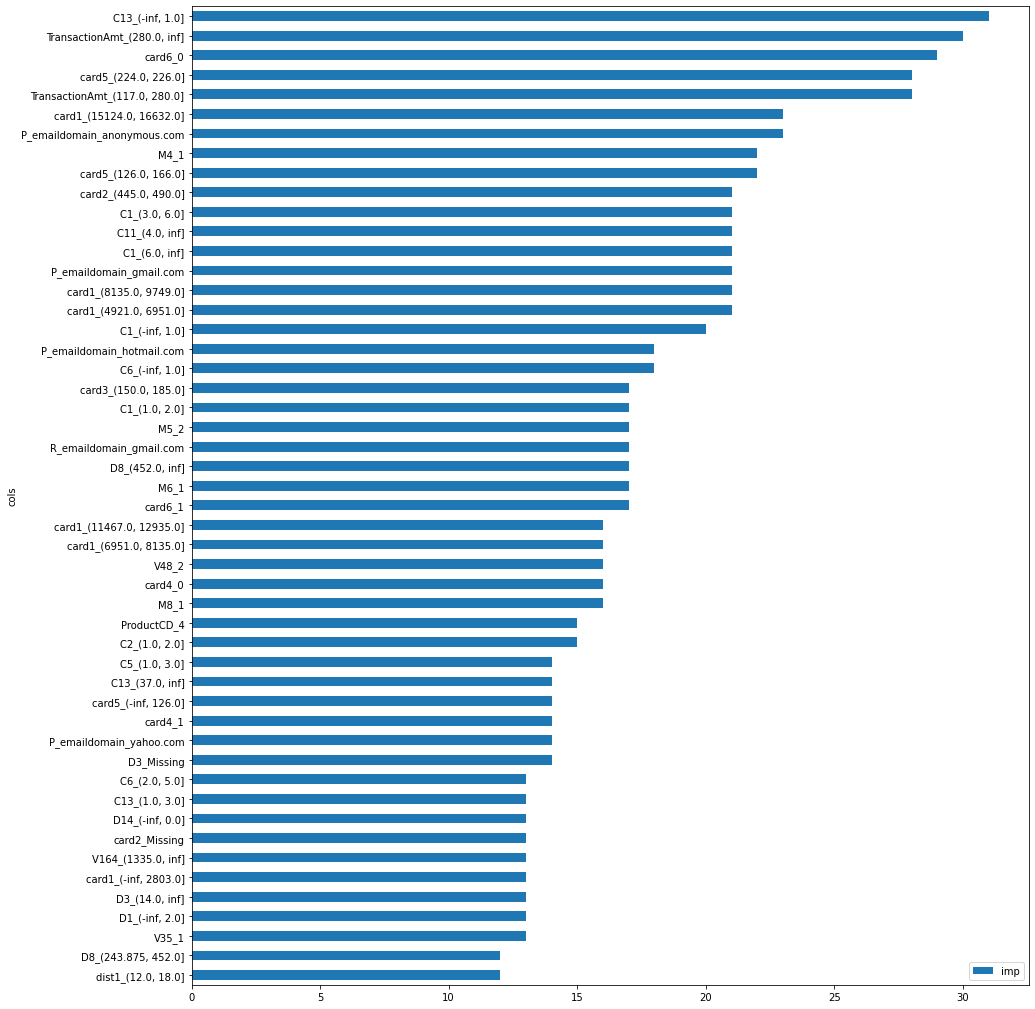

In [208]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model_n.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

##### Reducing stopping rounds

In [164]:

model2 = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=50, early_stopping_rounds=50)

[I 2020-09-15 23:12:56,960] A new study created in memory with name: no-name-fb355c3b-becc-4b1e-b2ff-cde685a975b5



  0%|                                                    | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0683267	valid_1's binary_logloss: 0.0920429
[100]	training's binary_logloss: 0.0514156	valid_1's binary_logloss: 0.089539
[150]	training's binary_logloss: 0.0409959	valid_1's binary_logloss: 0.0890056
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0429458	valid_1's binary_logloss: 0.0889227





feature_fraction, val_score: 0.088923:   0%|             | 0/7 [00:07<?, ?it/s]


feature_fraction, val_score: 0.088923:  14%|7    | 1/7 [00:07<00:44,  7.40s/it][I 2020-09-15 23:13:04,422] Trial 0 finished with value: 0.0889227468724072 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.0889227468724072.



feature_fraction, val_score: 0.088923:  14%|7    | 1/7 [00:07<00:44,  7.40s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0691322	valid_1's binary_logloss: 0.0921854
[100]	training's binary_logloss: 0.0522626	valid_1's binary_logloss: 0.0903024
[150]	training's binary_logloss: 0.0422469	valid_1's binary_logloss: 0.0890732
[200]	training's binary_logloss: 0.0347046	valid_1's binary_logloss: 0.0890083
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0355686	valid_1's binary_logloss: 0.088899





feature_fraction, val_score: 0.088899:  14%|7    | 1/7 [00:16<00:44,  7.40s/it]


feature_fraction, val_score: 0.088899:  29%|#4   | 2/7 [00:16<00:39,  7.97s/it][I 2020-09-15 23:13:13,696] Trial 1 finished with value: 0.08889895255437336 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.08889895255437336.



feature_fraction, val_score: 0.088899:  29%|#4   | 2/7 [00:16<00:39,  7.97s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0703431	valid_1's binary_logloss: 0.0928868
[100]	training's binary_logloss: 0.0537425	valid_1's binary_logloss: 0.0900071
[150]	training's binary_logloss: 0.0437951	valid_1's binary_logloss: 0.0892938
[200]	training's binary_logloss: 0.0360924	valid_1's binary_logloss: 0.0891362
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0426508	valid_1's binary_logloss: 0.0888423





feature_fraction, val_score: 0.088842:  29%|#4   | 2/7 [00:23<00:39,  7.97s/it]


feature_fraction, val_score: 0.088842:  43%|##1  | 3/7 [00:23<00:30,  7.58s/it][I 2020-09-15 23:13:20,359] Trial 2 finished with value: 0.08884226256685838 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.08884226256685838.



feature_fraction, val_score: 0.088842:  43%|##1  | 3/7 [00:23<00:30,  7.58s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0667918	valid_1's binary_logloss: 0.0922138
[100]	training's binary_logloss: 0.050197	valid_1's binary_logloss: 0.0898831
[150]	training's binary_logloss: 0.0395831	valid_1's binary_logloss: 0.0903764
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0466093	valid_1's binary_logloss: 0.0897472





feature_fraction, val_score: 0.088842:  43%|##1  | 3/7 [00:31<00:30,  7.58s/it]


feature_fraction, val_score: 0.088842:  57%|##8  | 4/7 [00:31<00:22,  7.66s/it][I 2020-09-15 23:13:28,208] Trial 3 finished with value: 0.0897472213078895 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.08884226256685838.



feature_fraction, val_score: 0.088842:  57%|##8  | 4/7 [00:31<00:22,  7.66s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0690809	valid_1's binary_logloss: 0.0931096
[100]	training's binary_logloss: 0.0523114	valid_1's binary_logloss: 0.0901961
[150]	training's binary_logloss: 0.0418373	valid_1's binary_logloss: 0.0897241
[200]	training's binary_logloss: 0.0349862	valid_1's binary_logloss: 0.0897997
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0362217	valid_1's binary_logloss: 0.089393





feature_fraction, val_score: 0.088842:  57%|##8  | 4/7 [00:38<00:22,  7.66s/it]


feature_fraction, val_score: 0.088842:  71%|###5 | 5/7 [00:38<00:15,  7.69s/it][I 2020-09-15 23:13:35,961] Trial 4 finished with value: 0.08939299053689721 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.08884226256685838.



feature_fraction, val_score: 0.088842:  71%|###5 | 5/7 [00:38<00:15,  7.69s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0675591	valid_1's binary_logloss: 0.0921725
[100]	training's binary_logloss: 0.0510591	valid_1's binary_logloss: 0.0900227
[150]	training's binary_logloss: 0.0399227	valid_1's binary_logloss: 0.0904098
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0492248	valid_1's binary_logloss: 0.089894





feature_fraction, val_score: 0.088842:  71%|###5 | 5/7 [00:45<00:15,  7.69s/it]


feature_fraction, val_score: 0.088842:  86%|####2| 6/7 [00:45<00:07,  7.44s/it][I 2020-09-15 23:13:42,812] Trial 5 finished with value: 0.08989395065914015 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.08884226256685838.



feature_fraction, val_score: 0.088842:  86%|####2| 6/7 [00:45<00:07,  7.44s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670257	valid_1's binary_logloss: 0.0918441
[100]	training's binary_logloss: 0.050121	valid_1's binary_logloss: 0.0885999
[150]	training's binary_logloss: 0.0393542	valid_1's binary_logloss: 0.087632
[200]	training's binary_logloss: 0.0322736	valid_1's binary_logloss: 0.0877205
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0359583	valid_1's binary_logloss: 0.0874136





feature_fraction, val_score: 0.087414:  86%|####2| 6/7 [00:54<00:07,  7.44s/it]


feature_fraction, val_score: 0.087414: 100%|#####| 7/7 [00:54<00:00,  7.72s/it]



  0%|                                                   | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 0.087414:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0577905	valid_1's binary_logloss: 0.0907518
[100]	training's binary_logloss: 0.0399751	valid_1's binary_logloss: 0.08971
[150]	training's binary_logloss: 0.0294812	valid_1's binary_logloss: 0.090133
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0365214	valid_1's binary_logloss: 0.0895628





num_leaves, val_score: 0.087414:   0%|                  | 0/20 [00:07<?, ?it/s]


num_leaves, val_score: 0.087414:   5%|5         | 1/20 [00:07<02:31,  7.97s/it][I 2020-09-15 23:13:59,046] Trial 7 finished with value: 0.089562827010829 and parameters: {'num_leaves': 44}. Best is trial 7 with value: 0.089562827010829.



num_leaves, val_score: 0.087414:   5%|5         | 1/20 [00:07<02:31,  7.97s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0640651	valid_1's binary_logloss: 0.0913027
[100]	training's binary_logloss: 0.0470492	valid_1's binary_logloss: 0.0889118
[150]	training's binary_logloss: 0.0363966	valid_1's binary_logloss: 0.0886291
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0388728	valid_1's binary_logloss: 0.0885151





num_leaves, val_score: 0.087414:   5%|5         | 1/20 [00:15<02:31,  7.97s/it]


num_leaves, val_score: 0.087414:  10%|#         | 2/20 [00:15<02:18,  7.72s/it][I 2020-09-15 23:14:06,179] Trial 8 finished with value: 0.08851507413958028 and parameters: {'num_leaves': 35}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  10%|#         | 2/20 [00:15<02:18,  7.72s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0253074	valid_1's binary_logloss: 0.0940003
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0333002	valid_1's binary_logloss: 0.0934078





num_leaves, val_score: 0.087414:  10%|#         | 2/20 [00:21<02:18,  7.72s/it]


num_leaves, val_score: 0.087414:  15%|#5        | 3/20 [00:21<02:05,  7.41s/it][I 2020-09-15 23:14:12,859] Trial 9 finished with value: 0.0934078036759455 and parameters: {'num_leaves': 146}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  15%|#5        | 3/20 [00:21<02:05,  7.41s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0164858	valid_1's binary_logloss: 0.0968493
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0325801	valid_1's binary_logloss: 0.0932131





num_leaves, val_score: 0.087414:  15%|#5        | 3/20 [00:30<02:05,  7.41s/it]


num_leaves, val_score: 0.087414:  20%|##        | 4/20 [00:30<02:03,  7.75s/it][I 2020-09-15 23:14:21,404] Trial 10 finished with value: 0.0932131342190916 and parameters: {'num_leaves': 219}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  20%|##        | 4/20 [00:30<02:03,  7.75s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.118397	valid_1's binary_logloss: 0.116565
[100]	training's binary_logloss: 0.113903	valid_1's binary_logloss: 0.112634
[150]	training's binary_logloss: 0.111479	valid_1's binary_logloss: 0.11043
[200]	training's binary_logloss: 0.109723	valid_1's binary_logloss: 0.108884
[250]	training's binary_logloss: 0.108343	valid_1's binary_logloss: 0.107622
[300]	training's binary_logloss: 0.107219	valid_1's binary_logloss: 0.106642
[350]	training's binary_logloss: 0.10628	valid_1's binary_logloss: 0.105898
[400]	training's binary_logloss: 0.10548	valid_1's binary_logloss: 0.105109
[450]	training's binary_logloss: 0.104787	valid_1's binary_logloss: 0.104542
[500]	training's binary_logloss: 0.104179	valid_1's binary_logloss: 0.103998
[550]	training's binary_logloss: 0.10364	valid_1's binary_logloss: 0.103654
[600]	training's binary_logloss: 0.103156	valid_1's binary_logloss: 0.1033
[650]	training's binar




num_leaves, val_score: 0.087414:  20%|##        | 4/20 [00:51<02:03,  7.75s/it]


num_leaves, val_score: 0.087414:  25%|##5       | 5/20 [00:51<02:56, 11.74s/it][I 2020-09-15 23:14:42,473] Trial 11 finished with value: 0.10162047836583452 and parameters: {'num_leaves': 2}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  25%|##5       | 5/20 [00:51<02:56, 11.74s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0450169	valid_1's binary_logloss: 0.0901582
[100]	training's binary_logloss: 0.0268297	valid_1's binary_logloss: 0.0916391
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0386474	valid_1's binary_logloss: 0.0900311





num_leaves, val_score: 0.087414:  25%|##5       | 5/20 [00:59<02:56, 11.74s/it]


num_leaves, val_score: 0.087414:  30%|###       | 6/20 [00:59<02:30, 10.77s/it][I 2020-09-15 23:14:50,983] Trial 12 finished with value: 0.0900310906318498 and parameters: {'num_leaves': 70}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  30%|###       | 6/20 [00:59<02:30, 10.77s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0306653	valid_1's binary_logloss: 0.0908157
[100]	training's binary_logloss: 0.0136455	valid_1's binary_logloss: 0.0971149
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0285616	valid_1's binary_logloss: 0.0906602





num_leaves, val_score: 0.087414:  30%|###       | 6/20 [01:07<02:30, 10.77s/it]


num_leaves, val_score: 0.087414:  35%|###5      | 7/20 [01:07<02:06,  9.69s/it][I 2020-09-15 23:14:58,153] Trial 13 finished with value: 0.0906601954000841 and parameters: {'num_leaves': 118}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  35%|###5      | 7/20 [01:07<02:06,  9.69s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0842908	valid_1's binary_logloss: 0.0959892
[100]	training's binary_logloss: 0.0707642	valid_1's binary_logloss: 0.092314
[150]	training's binary_logloss: 0.0617295	valid_1's binary_logloss: 0.0908588
[200]	training's binary_logloss: 0.0546663	valid_1's binary_logloss: 0.0904864
[250]	training's binary_logloss: 0.0484422	valid_1's binary_logloss: 0.0898665
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0496208	valid_1's binary_logloss: 0.0897576





num_leaves, val_score: 0.087414:  35%|###5      | 7/20 [01:16<02:06,  9.69s/it]


num_leaves, val_score: 0.087414:  40%|####      | 8/20 [01:16<01:56,  9.71s/it][I 2020-09-15 23:15:07,911] Trial 14 finished with value: 0.08975755793901376 and parameters: {'num_leaves': 15}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  40%|####      | 8/20 [01:16<01:56,  9.71s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0341072	valid_1's binary_logloss: 0.0908689
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0379762	valid_1's binary_logloss: 0.0906519





num_leaves, val_score: 0.087414:  40%|####      | 8/20 [01:22<01:56,  9.71s/it]


num_leaves, val_score: 0.087414:  45%|####5     | 9/20 [01:22<01:35,  8.64s/it][I 2020-09-15 23:15:14,039] Trial 15 finished with value: 0.09065189932158947 and parameters: {'num_leaves': 103}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  45%|####5     | 9/20 [01:22<01:35,  8.64s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.020064	valid_1's binary_logloss: 0.09581
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0307515	valid_1's binary_logloss: 0.0935119





num_leaves, val_score: 0.087414:  45%|####5     | 9/20 [01:31<01:35,  8.64s/it]


num_leaves, val_score: 0.087414:  50%|####5    | 10/20 [01:31<01:25,  8.51s/it][I 2020-09-15 23:15:22,256] Trial 16 finished with value: 0.09351194512749601 and parameters: {'num_leaves': 180}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  50%|####5    | 10/20 [01:31<01:25,  8.51s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0483174	valid_1's binary_logloss: 0.0908361
[100]	training's binary_logloss: 0.02967	valid_1's binary_logloss: 0.0917122
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0441442	valid_1's binary_logloss: 0.0903294





num_leaves, val_score: 0.087414:  50%|####5    | 10/20 [01:36<01:25,  8.51s/it]


num_leaves, val_score: 0.087414:  55%|####9    | 11/20 [01:36<01:08,  7.62s/it][I 2020-09-15 23:15:27,800] Trial 17 finished with value: 0.09032941122456566 and parameters: {'num_leaves': 63}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  55%|####9    | 11/20 [01:36<01:08,  7.62s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.014581	valid_1's binary_logloss: 0.0982847
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0307645	valid_1's binary_logloss: 0.0938519





num_leaves, val_score: 0.087414:  55%|####9    | 11/20 [01:45<01:08,  7.62s/it]


num_leaves, val_score: 0.087414:  60%|#####3   | 12/20 [01:45<01:03,  7.99s/it][I 2020-09-15 23:15:36,667] Trial 18 finished with value: 0.09385185929466737 and parameters: {'num_leaves': 236}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  60%|#####3   | 12/20 [01:45<01:03,  7.99s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0698313	valid_1's binary_logloss: 0.0923787
[100]	training's binary_logloss: 0.0534059	valid_1's binary_logloss: 0.089787
[150]	training's binary_logloss: 0.0425713	valid_1's binary_logloss: 0.0888284
[200]	training's binary_logloss: 0.0351046	valid_1's binary_logloss: 0.0893953
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0413865	valid_1's binary_logloss: 0.0886815





num_leaves, val_score: 0.087414:  60%|#####3   | 12/20 [01:52<01:03,  7.99s/it]


num_leaves, val_score: 0.087414:  65%|#####8   | 13/20 [01:52<00:54,  7.82s/it][I 2020-09-15 23:15:44,064] Trial 19 finished with value: 0.08868152401108831 and parameters: {'num_leaves': 28}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  65%|#####8   | 13/20 [01:53<00:54,  7.82s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0413183	valid_1's binary_logloss: 0.0897924
[100]	training's binary_logloss: 0.0225479	valid_1's binary_logloss: 0.0907461
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0407296	valid_1's binary_logloss: 0.0897318





num_leaves, val_score: 0.087414:  65%|#####8   | 13/20 [01:59<00:54,  7.82s/it]


num_leaves, val_score: 0.087414:  70%|######3  | 14/20 [01:59<00:44,  7.50s/it][I 2020-09-15 23:15:50,812] Trial 20 finished with value: 0.0897317687074184 and parameters: {'num_leaves': 81}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  70%|######3  | 14/20 [01:59<00:44,  7.50s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0709644	valid_1's binary_logloss: 0.0925767
[100]	training's binary_logloss: 0.0539763	valid_1's binary_logloss: 0.0898012
[150]	training's binary_logloss: 0.043647	valid_1's binary_logloss: 0.0891575
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0438377	valid_1's binary_logloss: 0.089155





num_leaves, val_score: 0.087414:  70%|######3  | 14/20 [02:06<00:44,  7.50s/it]


num_leaves, val_score: 0.087414:  75%|######7  | 15/20 [02:06<00:36,  7.37s/it][I 2020-09-15 23:15:57,880] Trial 21 finished with value: 0.08915504424565222 and parameters: {'num_leaves': 27}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  75%|######7  | 15/20 [02:06<00:36,  7.37s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0901002	valid_1's binary_logloss: 0.0974762
[100]	training's binary_logloss: 0.0783778	valid_1's binary_logloss: 0.0932179
[150]	training's binary_logloss: 0.0707629	valid_1's binary_logloss: 0.0918049
[200]	training's binary_logloss: 0.0637448	valid_1's binary_logloss: 0.0903881
[250]	training's binary_logloss: 0.0585164	valid_1's binary_logloss: 0.0895692
[300]	training's binary_logloss: 0.0539062	valid_1's binary_logloss: 0.0893338
[350]	training's binary_logloss: 0.0500702	valid_1's binary_logloss: 0.0890848
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0502165	valid_1's binary_logloss: 0.0889978





num_leaves, val_score: 0.087414:  75%|######7  | 15/20 [02:18<00:36,  7.37s/it]


num_leaves, val_score: 0.087414:  80%|#######2 | 16/20 [02:19<00:35,  8.82s/it][I 2020-09-15 23:16:10,078] Trial 22 finished with value: 0.0889978430206715 and parameters: {'num_leaves': 11}. Best is trial 8 with value: 0.08851507413958028.



num_leaves, val_score: 0.087414:  80%|#######2 | 16/20 [02:19<00:35,  8.82s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0590197	valid_1's binary_logloss: 0.0904376
[100]	training's binary_logloss: 0.0410399	valid_1's binary_logloss: 0.0886149
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.0446335	valid_1's binary_logloss: 0.08833





num_leaves, val_score: 0.087414:  80%|#######2 | 16/20 [02:24<00:35,  8.82s/it]


num_leaves, val_score: 0.087414:  85%|#######6 | 17/20 [02:24<00:23,  7.90s/it][I 2020-09-15 23:16:15,836] Trial 23 finished with value: 0.0883299679951638 and parameters: {'num_leaves': 42}. Best is trial 23 with value: 0.0883299679951638.



num_leaves, val_score: 0.087414:  85%|#######6 | 17/20 [02:24<00:23,  7.90s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0264002	valid_1's binary_logloss: 0.0916518
[100]	training's binary_logloss: 0.0109359	valid_1's binary_logloss: 0.0992497
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0258459	valid_1's binary_logloss: 0.0916198





num_leaves, val_score: 0.087414:  85%|#######6 | 17/20 [02:33<00:23,  7.90s/it]


num_leaves, val_score: 0.087414:  90%|########1| 18/20 [02:33<00:16,  8.29s/it][I 2020-09-15 23:16:25,039] Trial 24 finished with value: 0.09161981008960357 and parameters: {'num_leaves': 138}. Best is trial 23 with value: 0.0883299679951638.



num_leaves, val_score: 0.087414:  90%|########1| 18/20 [02:33<00:16,  8.29s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0379628	valid_1's binary_logloss: 0.0907345
[100]	training's binary_logloss: 0.0195847	valid_1's binary_logloss: 0.0929921
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.032122	valid_1's binary_logloss: 0.0903087





num_leaves, val_score: 0.087414:  90%|########1| 18/20 [02:40<00:16,  8.29s/it]


num_leaves, val_score: 0.087414:  95%|########5| 19/20 [02:40<00:07,  7.79s/it][I 2020-09-15 23:16:31,668] Trial 25 finished with value: 0.09030871337372143 and parameters: {'num_leaves': 92}. Best is trial 23 with value: 0.0883299679951638.



num_leaves, val_score: 0.087414:  95%|########5| 19/20 [02:40<00:07,  7.79s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0538083	valid_1's binary_logloss: 0.0905085
[100]	training's binary_logloss: 0.0353972	valid_1's binary_logloss: 0.090172
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0493338	valid_1's binary_logloss: 0.0897303





num_leaves, val_score: 0.087414:  95%|########5| 19/20 [02:45<00:07,  7.79s/it]


num_leaves, val_score: 0.087414: 100%|#########| 20/20 [02:45<00:00,  8.29s/it]



  0%|                                                   | 0/10 [00:00<?, ?it/s]


bagging, val_score: 0.087414:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0675168	valid_1's binary_logloss: 0.0922103
[100]	training's binary_logloss: 0.0499348	valid_1's binary_logloss: 0.08955
[150]	training's binary_logloss: 0.0385383	valid_1's binary_logloss: 0.0904822
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.045866	valid_1's binary_logloss: 0.089322





bagging, val_score: 0.087414:   0%|                     | 0/10 [00:06<?, ?it/s]


bagging, val_score: 0.087414:  10%|#3           | 1/10 [00:06<01:00,  6.68s/it][I 2020-09-15 23:16:43,568] Trial 27 finished with value: 0.08932203900785264 and parameters: {'bagging_fraction': 0.8067982754989251, 'bagging_freq': 6}. Best is trial 27 with value: 0.08932203900785264.



bagging, val_score: 0.087414:  10%|#3           | 1/10 [00:06<01:00,  6.68s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0691484	valid_1's binary_logloss: 0.0936447
[100]	training's binary_logloss: 0.049754	valid_1's binary_logloss: 0.0929131
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0560164	valid_1's binary_logloss: 0.0924444





bagging, val_score: 0.087414:  10%|#3           | 1/10 [00:10<01:00,  6.68s/it]


bagging, val_score: 0.087414:  20%|##6          | 2/10 [00:10<00:46,  5.83s/it][I 2020-09-15 23:16:47,417] Trial 28 finished with value: 0.0924443835388899 and parameters: {'bagging_fraction': 0.438382985815274, 'bagging_freq': 1}. Best is trial 27 with value: 0.08932203900785264.



bagging, val_score: 0.087414:  20%|##6          | 2/10 [00:10<00:46,  5.83s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0690674	valid_1's binary_logloss: 0.0949496
[100]	training's binary_logloss: 0.0495132	valid_1's binary_logloss: 0.0925938
[150]	training's binary_logloss: 0.0378577	valid_1's binary_logloss: 0.0928723
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0434498	valid_1's binary_logloss: 0.0921956





bagging, val_score: 0.087414:  20%|##6          | 2/10 [00:15<00:46,  5.83s/it]


bagging, val_score: 0.087414:  30%|###9         | 3/10 [00:15<00:38,  5.54s/it][I 2020-09-15 23:16:52,280] Trial 29 finished with value: 0.0921956457309296 and parameters: {'bagging_fraction': 0.4027306225392879, 'bagging_freq': 1}. Best is trial 27 with value: 0.08932203900785264.



bagging, val_score: 0.087414:  30%|###9         | 3/10 [00:15<00:38,  5.54s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670264	valid_1's binary_logloss: 0.0923014
[100]	training's binary_logloss: 0.0497068	valid_1's binary_logloss: 0.0888205
[150]	training's binary_logloss: 0.0391794	valid_1's binary_logloss: 0.0877402
[200]	training's binary_logloss: 0.031981	valid_1's binary_logloss: 0.0886235
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0385707	valid_1's binary_logloss: 0.0876252





bagging, val_score: 0.087414:  30%|###9         | 3/10 [00:24<00:38,  5.54s/it]


bagging, val_score: 0.087414:  40%|#####2       | 4/10 [00:24<00:39,  6.56s/it][I 2020-09-15 23:17:01,230] Trial 30 finished with value: 0.08762518407679672 and parameters: {'bagging_fraction': 0.9910967320605599, 'bagging_freq': 7}. Best is trial 30 with value: 0.08762518407679672.



bagging, val_score: 0.087414:  40%|#####2       | 4/10 [00:24<00:39,  6.56s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670892	valid_1's binary_logloss: 0.0909723
[100]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0881528
[150]	training's binary_logloss: 0.0395929	valid_1's binary_logloss: 0.0874169
[200]	training's binary_logloss: 0.032233	valid_1's binary_logloss: 0.0878719
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0385691	valid_1's binary_logloss: 0.0872681





bagging, val_score: 0.087268:  40%|#####2       | 4/10 [00:33<00:39,  6.56s/it]


bagging, val_score: 0.087268:  50%|######5      | 5/10 [00:33<00:36,  7.37s/it][I 2020-09-15 23:17:10,489] Trial 31 finished with value: 0.08726808454719462 and parameters: {'bagging_fraction': 0.9880932286085656, 'bagging_freq': 7}. Best is trial 31 with value: 0.08726808454719462.



bagging, val_score: 0.087268:  50%|######5      | 5/10 [00:33<00:36,  7.37s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0679737	valid_1's binary_logloss: 0.093089
[100]	training's binary_logloss: 0.050819	valid_1's binary_logloss: 0.0908274
[150]	training's binary_logloss: 0.0400115	valid_1's binary_logloss: 0.0906314
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0404783	valid_1's binary_logloss: 0.0904688





bagging, val_score: 0.087268:  50%|######5      | 5/10 [00:41<00:36,  7.37s/it]


bagging, val_score: 0.087268:  60%|#######8     | 6/10 [00:41<00:30,  7.67s/it][I 2020-09-15 23:17:18,858] Trial 32 finished with value: 0.09046875248037616 and parameters: {'bagging_fraction': 0.9672282111936323, 'bagging_freq': 7}. Best is trial 31 with value: 0.08726808454719462.



bagging, val_score: 0.087268:  60%|#######8     | 6/10 [00:41<00:30,  7.67s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0675104	valid_1's binary_logloss: 0.092044
[100]	training's binary_logloss: 0.0505523	valid_1's binary_logloss: 0.0898345
[150]	training's binary_logloss: 0.0403187	valid_1's binary_logloss: 0.0895589
[200]	training's binary_logloss: 0.03265	valid_1's binary_logloss: 0.0893943
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0351043	valid_1's binary_logloss: 0.0889953





bagging, val_score: 0.087268:  60%|#######8     | 6/10 [00:52<00:30,  7.67s/it]


bagging, val_score: 0.087268:  70%|#########1   | 7/10 [00:52<00:25,  8.38s/it][I 2020-09-15 23:17:28,908] Trial 33 finished with value: 0.08899532758465871 and parameters: {'bagging_fraction': 0.9875763881396192, 'bagging_freq': 5}. Best is trial 31 with value: 0.08726808454719462.



bagging, val_score: 0.087268:  70%|#########1   | 7/10 [00:52<00:25,  8.38s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0674078	valid_1's binary_logloss: 0.0937559
[100]	training's binary_logloss: 0.049594	valid_1's binary_logloss: 0.0901287
[150]	training's binary_logloss: 0.0386405	valid_1's binary_logloss: 0.0896075
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0394902	valid_1's binary_logloss: 0.0895663





bagging, val_score: 0.087268:  70%|#########1   | 7/10 [00:59<00:25,  8.38s/it]


bagging, val_score: 0.087268:  80%|##########4  | 8/10 [00:59<00:15,  7.99s/it][I 2020-09-15 23:17:35,992] Trial 34 finished with value: 0.08956631590860034 and parameters: {'bagging_fraction': 0.8563488043552285, 'bagging_freq': 7}. Best is trial 31 with value: 0.08726808454719462.



bagging, val_score: 0.087268:  80%|##########4  | 8/10 [00:59<00:15,  7.99s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0685937	valid_1's binary_logloss: 0.0943991
[100]	training's binary_logloss: 0.0498024	valid_1's binary_logloss: 0.0915407
[150]	training's binary_logloss: 0.0383284	valid_1's binary_logloss: 0.0919583
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0396859	valid_1's binary_logloss: 0.0912292





bagging, val_score: 0.087268:  80%|##########4  | 8/10 [01:06<00:15,  7.99s/it]


bagging, val_score: 0.087268:  90%|###########7 | 9/10 [01:06<00:07,  7.82s/it][I 2020-09-15 23:17:43,411] Trial 35 finished with value: 0.09122915249947942 and parameters: {'bagging_fraction': 0.6313829599476499, 'bagging_freq': 3}. Best is trial 31 with value: 0.08726808454719462.



bagging, val_score: 0.087268:  90%|###########7 | 9/10 [01:06<00:07,  7.82s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.067162	valid_1's binary_logloss: 0.0924287
[100]	training's binary_logloss: 0.0502001	valid_1's binary_logloss: 0.090205
[150]	training's binary_logloss: 0.0394455	valid_1's binary_logloss: 0.0893842
[200]	training's binary_logloss: 0.0321865	valid_1's binary_logloss: 0.0897915
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0365337	valid_1's binary_logloss: 0.088993





bagging, val_score: 0.087268:  90%|###########7 | 9/10 [01:15<00:07,  7.82s/it]


bagging, val_score: 0.087268: 100%|############| 10/10 [01:15<00:00,  7.54s/it]



  0%|                                                    | 0/6 [00:00<?, ?it/s]


feature_fraction_stage2, val_score: 0.087268:   0%|      | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0671775	valid_1's binary_logloss: 0.0924551
[100]	training's binary_logloss: 0.0504176	valid_1's binary_logloss: 0.0900184
[150]	training's binary_logloss: 0.039567	valid_1's binary_logloss: 0.0896388
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0429239	valid_1's binary_logloss: 0.0895291





feature_fraction_stage2, val_score: 0.087268:   0%|      | 0/6 [00:08<?, ?it/s]


feature_fraction_stage2, val_score: 0.087268:  17%|1| 1/6 [00:08<00:42,  8.48s/[I 2020-09-15 23:18:00,814] Trial 37 finished with value: 0.08952911603497728 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.08952911603497728.



feature_fraction_stage2, val_score: 0.087268:  17%|1| 1/6 [00:08<00:42,  8.48s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0681014	valid_1's binary_logloss: 0.0939004
[100]	training's binary_logloss: 0.0509871	valid_1's binary_logloss: 0.0912965
[150]	training's binary_logloss: 0.0400721	valid_1's binary_logloss: 0.0902978
[200]	training's binary_logloss: 0.0327251	valid_1's binary_logloss: 0.0907324
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0369083	valid_1's binary_logloss: 0.0900816





feature_fraction_stage2, val_score: 0.087268:  17%|1| 1/6 [00:16<00:42,  8.48s/


feature_fraction_stage2, val_score: 0.087268:  33%|3| 2/6 [00:16<00:33,  8.49s/[I 2020-09-15 23:18:09,315] Trial 38 finished with value: 0.09008155301571108 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.08952911603497728.



feature_fraction_stage2, val_score: 0.087268:  33%|3| 2/6 [00:17<00:33,  8.49s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0676806	valid_1's binary_logloss: 0.0911568
[100]	training's binary_logloss: 0.050448	valid_1's binary_logloss: 0.0888184
[150]	training's binary_logloss: 0.0393217	valid_1's binary_logloss: 0.0874703
[200]	training's binary_logloss: 0.0322914	valid_1's binary_logloss: 0.0880399
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0391681	valid_1's binary_logloss: 0.0874209





feature_fraction_stage2, val_score: 0.087268:  33%|3| 2/6 [00:26<00:33,  8.49s/


feature_fraction_stage2, val_score: 0.087268:  50%|5| 3/6 [00:26<00:26,  8.69s/[I 2020-09-15 23:18:18,467] Trial 39 finished with value: 0.08742089314064688 and parameters: {'feature_fraction': 0.852}. Best is trial 39 with value: 0.08742089314064688.



feature_fraction_stage2, val_score: 0.087268:  50%|5| 3/6 [00:26<00:26,  8.69s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672309	valid_1's binary_logloss: 0.0920393
[100]	training's binary_logloss: 0.0498968	valid_1's binary_logloss: 0.0885845
[150]	training's binary_logloss: 0.0393265	valid_1's binary_logloss: 0.0885436
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0443108	valid_1's binary_logloss: 0.0881661





feature_fraction_stage2, val_score: 0.087268:  50%|5| 3/6 [00:33<00:26,  8.69s/


feature_fraction_stage2, val_score: 0.087268:  67%|6| 4/6 [00:33<00:16,  8.27s/[I 2020-09-15 23:18:25,774] Trial 40 finished with value: 0.08816606414501164 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 39 with value: 0.08742089314064688.



feature_fraction_stage2, val_score: 0.087268:  67%|6| 4/6 [00:33<00:16,  8.27s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.067454	valid_1's binary_logloss: 0.0921206
[100]	training's binary_logloss: 0.0504297	valid_1's binary_logloss: 0.0899289
[150]	training's binary_logloss: 0.0397061	valid_1's binary_logloss: 0.0896843
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0430979	valid_1's binary_logloss: 0.0894128





feature_fraction_stage2, val_score: 0.087268:  67%|6| 4/6 [00:41<00:16,  8.27s/


feature_fraction_stage2, val_score: 0.087268:  83%|8| 5/6 [00:41<00:08,  8.29s/[I 2020-09-15 23:18:34,102] Trial 41 finished with value: 0.08941284701105161 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 39 with value: 0.08742089314064688.



feature_fraction_stage2, val_score: 0.087268:  83%|8| 5/6 [00:41<00:08,  8.29s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0668608	valid_1's binary_logloss: 0.0930497
[100]	training's binary_logloss: 0.0500612	valid_1's binary_logloss: 0.0899164
[150]	training's binary_logloss: 0.0399341	valid_1's binary_logloss: 0.0890964
[200]	training's binary_logloss: 0.0320569	valid_1's binary_logloss: 0.0897876
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0384117	valid_1's binary_logloss: 0.0890229





feature_fraction_stage2, val_score: 0.087268:  83%|8| 5/6 [00:50<00:08,  8.29s/


feature_fraction_stage2, val_score: 0.087268: 100%|#| 6/6 [00:50<00:00,  8.27s/[I 2020-09-15 23:18:42,342] Trial 42 finished with value: 0.08902286846593523 and parameters: {'feature_fraction': 0.948}. Best is trial 39 with value: 0.08742089314064688.
feature_fraction_stage2, val_score: 0.087268: 100%|#| 6/6 [00:50<00:00,  8.34s/



  0%|                                                   | 0/20 [00:00<?, ?it/s]


regularization_factors, val_score: 0.087268:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0690135	valid_1's binary_logloss: 0.092008
[100]	training's binary_logloss: 0.0525208	valid_1's binary_logloss: 0.0896111
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0536281	valid_1's binary_logloss: 0.0894385





regularization_factors, val_score: 0.087268:   0%|      | 0/20 [00:06<?, ?it/s]


regularization_factors, val_score: 0.087268:   5%| | 1/20 [00:06<02:06,  6.64s/[I 2020-09-15 23:18:49,029] Trial 43 finished with value: 0.08943852646759205 and parameters: {'lambda_l1': 0.1588558640933569, 'lambda_l2': 3.7097783774467366e-05}. Best is trial 43 with value: 0.08943852646759205.



regularization_factors, val_score: 0.087268:   5%| | 1/20 [00:06<02:06,  6.64s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0794594	valid_1's binary_logloss: 0.0945202
[100]	training's binary_logloss: 0.0660483	valid_1's binary_logloss: 0.0909168
[150]	training's binary_logloss: 0.0578491	valid_1's binary_logloss: 0.0903711
[200]	training's binary_logloss: 0.0514567	valid_1's binary_logloss: 0.0901984
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.055092	valid_1's binary_logloss: 0.0901644





regularization_factors, val_score: 0.087268:   5%| | 1/20 [00:15<02:06,  6.64s/


regularization_factors, val_score: 0.087268:  10%|1| 2/20 [00:15<02:11,  7.31s/[I 2020-09-15 23:18:57,888] Trial 44 finished with value: 0.09016444444075544 and parameters: {'lambda_l1': 1.3850934403699415e-08, 'lambda_l2': 5.282812516902232}. Best is trial 43 with value: 0.08943852646759205.



regularization_factors, val_score: 0.087268:  10%|1| 2/20 [00:15<02:11,  7.31s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670892	valid_1's binary_logloss: 0.0909721
[100]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0881527
[150]	training's binary_logloss: 0.0393819	valid_1's binary_logloss: 0.0875271
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0425387	valid_1's binary_logloss: 0.0874943





regularization_factors, val_score: 0.087268:  10%|1| 2/20 [00:23<02:11,  7.31s/


regularization_factors, val_score: 0.087268:  15%|1| 3/20 [00:23<02:09,  7.61s/[I 2020-09-15 23:19:06,196] Trial 45 finished with value: 0.08749427884843773 and parameters: {'lambda_l1': 3.783107718839151e-08, 'lambda_l2': 2.5271054359768657e-08}. Best is trial 45 with value: 0.08749427884843773.



regularization_factors, val_score: 0.087268:  15%|1| 3/20 [00:23<02:09,  7.61s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0673584	valid_1's binary_logloss: 0.0911693
[100]	training's binary_logloss: 0.0499544	valid_1's binary_logloss: 0.0882151
[150]	training's binary_logloss: 0.0391915	valid_1's binary_logloss: 0.0877049
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0421153	valid_1's binary_logloss: 0.0876436





regularization_factors, val_score: 0.087268:  15%|1| 3/20 [00:31<02:09,  7.61s/


regularization_factors, val_score: 0.087268:  20%|2| 4/20 [00:31<02:01,  7.56s/[I 2020-09-15 23:19:13,655] Trial 46 finished with value: 0.08764355914726144 and parameters: {'lambda_l1': 1.0590839981944484e-07, 'lambda_l2': 1.1391981537350695e-08}. Best is trial 45 with value: 0.08749427884843773.



regularization_factors, val_score: 0.087268:  20%|2| 4/20 [00:31<02:01,  7.56s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0675228	valid_1's binary_logloss: 0.0918827
[100]	training's binary_logloss: 0.0503832	valid_1's binary_logloss: 0.0884552
[150]	training's binary_logloss: 0.0397945	valid_1's binary_logloss: 0.0880136
[200]	training's binary_logloss: 0.0322121	valid_1's binary_logloss: 0.0891164
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0366274	valid_1's binary_logloss: 0.0879389





regularization_factors, val_score: 0.087268:  20%|2| 4/20 [00:40<02:01,  7.56s/


regularization_factors, val_score: 0.087268:  25%|2| 5/20 [00:40<02:02,  8.18s/[I 2020-09-15 23:19:23,265] Trial 47 finished with value: 0.08793889010127084 and parameters: {'lambda_l1': 2.419170961486912e-05, 'lambda_l2': 3.325126706506527e-08}. Best is trial 45 with value: 0.08749427884843773.



regularization_factors, val_score: 0.087268:  25%|2| 5/20 [00:40<02:02,  8.18s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.06766	valid_1's binary_logloss: 0.0921852
[100]	training's binary_logloss: 0.0503983	valid_1's binary_logloss: 0.0895724
[150]	training's binary_logloss: 0.039845	valid_1's binary_logloss: 0.0886496
[200]	training's binary_logloss: 0.032449	valid_1's binary_logloss: 0.0898117
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0396766	valid_1's binary_logloss: 0.0885954





regularization_factors, val_score: 0.087268:  25%|2| 5/20 [00:48<02:02,  8.18s/


regularization_factors, val_score: 0.087268:  30%|3| 6/20 [00:48<01:53,  8.11s/[I 2020-09-15 23:19:31,211] Trial 48 finished with value: 0.08859538138655655 and parameters: {'lambda_l1': 2.598592660560242e-05, 'lambda_l2': 4.346169353386533e-05}. Best is trial 45 with value: 0.08749427884843773.



regularization_factors, val_score: 0.087268:  30%|3| 6/20 [00:48<01:53,  8.11s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0882136	valid_1's binary_logloss: 0.0964114
[100]	training's binary_logloss: 0.0827949	valid_1's binary_logloss: 0.0944539
[150]	training's binary_logloss: 0.0813676	valid_1's binary_logloss: 0.0940774
[200]	training's binary_logloss: 0.0812364	valid_1's binary_logloss: 0.0940416
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0812364	valid_1's binary_logloss: 0.0940416





regularization_factors, val_score: 0.087268:  30%|3| 6/20 [00:55<01:53,  8.11s/


regularization_factors, val_score: 0.087268:  35%|3| 7/20 [00:55<01:38,  7.60s/[I 2020-09-15 23:19:37,628] Trial 49 finished with value: 0.0940416372133189 and parameters: {'lambda_l1': 7.960143006156404, 'lambda_l2': 1.3165995713300038}. Best is trial 45 with value: 0.08749427884843773.



regularization_factors, val_score: 0.087268:  35%|3| 7/20 [00:55<01:38,  7.60s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0681988	valid_1's binary_logloss: 0.0930869
[100]	training's binary_logloss: 0.0507852	valid_1's binary_logloss: 0.0905249
[150]	training's binary_logloss: 0.0397994	valid_1's binary_logloss: 0.0894752
[200]	training's binary_logloss: 0.0321231	valid_1's binary_logloss: 0.0897948
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0357175	valid_1's binary_logloss: 0.0893861





regularization_factors, val_score: 0.087268:  35%|3| 7/20 [01:05<01:38,  7.60s/


regularization_factors, val_score: 0.087268:  40%|4| 8/20 [01:05<01:40,  8.36s/[I 2020-09-15 23:19:47,774] Trial 50 finished with value: 0.08938609372363238 and parameters: {'lambda_l1': 3.047362593038478e-07, 'lambda_l2': 0.012302501864666979}. Best is trial 45 with value: 0.08749427884843773.



regularization_factors, val_score: 0.087268:  40%|4| 8/20 [01:05<01:40,  8.36s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670892	valid_1's binary_logloss: 0.0909721
[100]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0881527
[150]	training's binary_logloss: 0.0393819	valid_1's binary_logloss: 0.0875271
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0425387	valid_1's binary_logloss: 0.0874943





regularization_factors, val_score: 0.087268:  40%|4| 8/20 [01:15<01:40,  8.36s/


regularization_factors, val_score: 0.087268:  45%|4| 9/20 [01:15<01:36,  8.75s/[I 2020-09-15 23:19:57,430] Trial 51 finished with value: 0.08749427883850297 and parameters: {'lambda_l1': 4.320427383094865e-08, 'lambda_l2': 2.6747863217317074e-08}. Best is trial 51 with value: 0.08749427883850297.



regularization_factors, val_score: 0.087268:  45%|4| 9/20 [01:15<01:36,  8.75s/

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670892	valid_1's binary_logloss: 0.0909723
[100]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0881528
[150]	training's binary_logloss: 0.0393819	valid_1's binary_logloss: 0.0875271
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0425387	valid_1's binary_logloss: 0.0874943





regularization_factors, val_score: 0.087268:  45%|4| 9/20 [01:22<01:36,  8.75s/


regularization_factors, val_score: 0.087268:  50%|5| 10/20 [01:22<01:23,  8.39s[I 2020-09-15 23:20:04,991] Trial 52 finished with value: 0.08749433725489006 and parameters: {'lambda_l1': 1.112933351694056e-08, 'lambda_l2': 3.27623884150021e-07}. Best is trial 51 with value: 0.08749427883850297.



regularization_factors, val_score: 0.087268:  50%|5| 10/20 [01:22<01:23,  8.39s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670892	valid_1's binary_logloss: 0.0909721
[100]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0881527
[150]	training's binary_logloss: 0.0395929	valid_1's binary_logloss: 0.0874164
[200]	training's binary_logloss: 0.032233	valid_1's binary_logloss: 0.0878716
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0385691	valid_1's binary_logloss: 0.0872676





regularization_factors, val_score: 0.087268:  50%|5| 10/20 [01:32<01:23,  8.39s


regularization_factors, val_score: 0.087268:  55%|5| 11/20 [01:32<01:18,  8.70s[I 2020-09-15 23:20:14,396] Trial 53 finished with value: 0.08726759786234496 and parameters: {'lambda_l1': 1.1363064155497873e-08, 'lambda_l2': 1.0475815094476405e-07}. Best is trial 53 with value: 0.08726759786234496.



regularization_factors, val_score: 0.087268:  55%|5| 11/20 [01:32<01:18,  8.70s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0673584	valid_1's binary_logloss: 0.0911693
[100]	training's binary_logloss: 0.0499544	valid_1's binary_logloss: 0.0882151
[150]	training's binary_logloss: 0.0391915	valid_1's binary_logloss: 0.0877049
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0421153	valid_1's binary_logloss: 0.0876436





regularization_factors, val_score: 0.087268:  55%|5| 11/20 [01:41<01:18,  8.70s


regularization_factors, val_score: 0.087268:  60%|6| 12/20 [01:41<01:10,  8.84s[I 2020-09-15 23:20:23,561] Trial 54 finished with value: 0.08764355818505397 and parameters: {'lambda_l1': 2.0603584699275266e-07, 'lambda_l2': 2.8789354421558096e-07}. Best is trial 53 with value: 0.08726759786234496.



regularization_factors, val_score: 0.087268:  60%|6| 12/20 [01:41<01:10,  8.84s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0670892	valid_1's binary_logloss: 0.0909723
[100]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0881528
[150]	training's binary_logloss: 0.0395929	valid_1's binary_logloss: 0.0874165
[200]	training's binary_logloss: 0.032233	valid_1's binary_logloss: 0.0878716
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0385691	valid_1's binary_logloss: 0.0872677





regularization_factors, val_score: 0.087268:  60%|6| 12/20 [01:50<01:10,  8.84s


regularization_factors, val_score: 0.087268:  65%|6| 13/20 [01:50<01:02,  8.95s[I 2020-09-15 23:20:32,779] Trial 55 finished with value: 0.08726766414179223 and parameters: {'lambda_l1': 1.0096311852894665e-08, 'lambda_l2': 1.1189418592074e-08}. Best is trial 53 with value: 0.08726759786234496.



regularization_factors, val_score: 0.087268:  65%|6| 13/20 [01:50<01:02,  8.95s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672355	valid_1's binary_logloss: 0.0908751
[100]	training's binary_logloss: 0.0500408	valid_1's binary_logloss: 0.0875613
[150]	training's binary_logloss: 0.0395044	valid_1's binary_logloss: 0.086913
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0423057	valid_1's binary_logloss: 0.0867953





regularization_factors, val_score: 0.086795:  65%|6| 13/20 [02:00<01:02,  8.95s


regularization_factors, val_score: 0.086795:  70%|7| 14/20 [02:00<00:56,  9.35s[I 2020-09-15 23:20:43,048] Trial 56 finished with value: 0.08679532008087743 and parameters: {'lambda_l1': 2.7445577876565753e-06, 'lambda_l2': 1.0515291002147425e-06}. Best is trial 56 with value: 0.08679532008087743.



regularization_factors, val_score: 0.086795:  70%|7| 14/20 [02:00<00:56,  9.35s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672862	valid_1's binary_logloss: 0.0910784
[100]	training's binary_logloss: 0.050285	valid_1's binary_logloss: 0.0880235
[150]	training's binary_logloss: 0.0400884	valid_1's binary_logloss: 0.0872017
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0408551	valid_1's binary_logloss: 0.08709





regularization_factors, val_score: 0.086795:  70%|7| 14/20 [02:09<00:56,  9.35s


regularization_factors, val_score: 0.086795:  75%|7| 15/20 [02:09<00:46,  9.32s[I 2020-09-15 23:20:52,319] Trial 57 finished with value: 0.08709003940174496 and parameters: {'lambda_l1': 8.131848211033477e-06, 'lambda_l2': 1.6260620621129654e-06}. Best is trial 56 with value: 0.08679532008087743.



regularization_factors, val_score: 0.086795:  75%|7| 15/20 [02:09<00:46,  9.32s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672862	valid_1's binary_logloss: 0.0910784
[100]	training's binary_logloss: 0.050285	valid_1's binary_logloss: 0.0880235
[150]	training's binary_logloss: 0.0401049	valid_1's binary_logloss: 0.0871478
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0406127	valid_1's binary_logloss: 0.0870137





regularization_factors, val_score: 0.086795:  75%|7| 15/20 [02:20<00:46,  9.32s


regularization_factors, val_score: 0.086795:  80%|8| 16/20 [02:20<00:38,  9.67s[I 2020-09-15 23:21:02,790] Trial 58 finished with value: 0.0870136845618331 and parameters: {'lambda_l1': 6.0114182247557505e-06, 'lambda_l2': 2.002351262003227e-06}. Best is trial 56 with value: 0.08679532008087743.



regularization_factors, val_score: 0.086795:  80%|8| 16/20 [02:20<00:38,  9.67s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672862	valid_1's binary_logloss: 0.0910785
[100]	training's binary_logloss: 0.050285	valid_1's binary_logloss: 0.0880235
[150]	training's binary_logloss: 0.0400884	valid_1's binary_logloss: 0.0872017
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0408551	valid_1's binary_logloss: 0.08709





regularization_factors, val_score: 0.086795:  80%|8| 16/20 [02:30<00:38,  9.67s


regularization_factors, val_score: 0.086795:  85%|8| 17/20 [02:30<00:29,  9.81s[I 2020-09-15 23:21:12,920] Trial 59 finished with value: 0.08709004038625588 and parameters: {'lambda_l1': 6.752805632402286e-06, 'lambda_l2': 2.1608341426027115e-06}. Best is trial 56 with value: 0.08679532008087743.



regularization_factors, val_score: 0.086795:  85%|8| 17/20 [02:30<00:29,  9.81s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672862	valid_1's binary_logloss: 0.0910785
[100]	training's binary_logloss: 0.0502851	valid_1's binary_logloss: 0.0880235
[150]	training's binary_logloss: 0.0400884	valid_1's binary_logloss: 0.0872016
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0408552	valid_1's binary_logloss: 0.08709





regularization_factors, val_score: 0.086795:  85%|8| 17/20 [02:38<00:29,  9.81s


regularization_factors, val_score: 0.086795:  90%|9| 18/20 [02:38<00:18,  9.24s[I 2020-09-15 23:21:20,848] Trial 60 finished with value: 0.08708995479362534 and parameters: {'lambda_l1': 1.3757275840939324e-05, 'lambda_l2': 2.2131704676355305e-06}. Best is trial 56 with value: 0.08679532008087743.



regularization_factors, val_score: 0.086795:  90%|9| 18/20 [02:38<00:18,  9.24s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672862	valid_1's binary_logloss: 0.0910785
[100]	training's binary_logloss: 0.050285	valid_1's binary_logloss: 0.0880235
[150]	training's binary_logloss: 0.0400884	valid_1's binary_logloss: 0.0872017
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0408551	valid_1's binary_logloss: 0.08709





regularization_factors, val_score: 0.086795:  90%|9| 18/20 [02:48<00:18,  9.24s


regularization_factors, val_score: 0.086795:  95%|9| 19/20 [02:48<00:09,  9.53s[I 2020-09-15 23:21:31,063] Trial 61 finished with value: 0.08709003776694184 and parameters: {'lambda_l1': 9.78405033049271e-06, 'lambda_l2': 1.954028616828821e-06}. Best is trial 56 with value: 0.08679532008087743.



regularization_factors, val_score: 0.086795:  95%|9| 19/20 [02:48<00:09,  9.53s

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672862	valid_1's binary_logloss: 0.0910785
[100]	training's binary_logloss: 0.0502851	valid_1's binary_logloss: 0.0880235
[150]	training's binary_logloss: 0.0400884	valid_1's binary_logloss: 0.0872016
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0408552	valid_1's binary_logloss: 0.08709





regularization_factors, val_score: 0.086795:  95%|9| 19/20 [02:56<00:09,  9.53s


regularization_factors, val_score: 0.086795: 100%|#| 20/20 [02:56<00:00,  9.14s[I 2020-09-15 23:21:39,283] Trial 62 finished with value: 0.08708995588641856 and parameters: {'lambda_l1': 1.2571892523240263e-05, 'lambda_l2': 2.2042095198984838e-06}. Best is trial 56 with value: 0.08679532008087743.
regularization_factors, val_score: 0.086795: 100%|#| 20/20 [02:56<00:00,  8.85s



  0%|                                                    | 0/5 [00:00<?, ?it/s]


min_data_in_leaf, val_score: 0.086795:   0%|             | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0680135	valid_1's binary_logloss: 0.0912762
[100]	training's binary_logloss: 0.0513425	valid_1's binary_logloss: 0.0885538
[150]	training's binary_logloss: 0.0405311	valid_1's binary_logloss: 0.0880244
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0458368	valid_1's binary_logloss: 0.0878784





min_data_in_leaf, val_score: 0.086795:   0%|             | 0/5 [00:08<?, ?it/s]


min_data_in_leaf, val_score: 0.086795:  20%|#    | 1/5 [00:08<00:33,  8.34s/it][I 2020-09-15 23:21:47,643] Trial 63 finished with value: 0.08787844753599654 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.08787844753599654.



min_data_in_leaf, val_score: 0.086795:  20%|#    | 1/5 [00:08<00:33,  8.34s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0646812	valid_1's binary_logloss: 0.0926684
[100]	training's binary_logloss: 0.047189	valid_1's binary_logloss: 0.0899283
[150]	training's binary_logloss: 0.0367093	valid_1's binary_logloss: 0.0892976
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0414174	valid_1's binary_logloss: 0.0891061





min_data_in_leaf, val_score: 0.086795:  20%|#    | 1/5 [00:16<00:33,  8.34s/it]


min_data_in_leaf, val_score: 0.086795:  40%|##   | 2/5 [00:16<00:24,  8.27s/it][I 2020-09-15 23:21:55,743] Trial 64 finished with value: 0.08910605465560223 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.08787844753599654.



min_data_in_leaf, val_score: 0.086795:  40%|##   | 2/5 [00:16<00:24,  8.27s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0710943	valid_1's binary_logloss: 0.0913198
[100]	training's binary_logloss: 0.0547735	valid_1's binary_logloss: 0.0887611
[150]	training's binary_logloss: 0.0439421	valid_1's binary_logloss: 0.0880582
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0444619	valid_1's binary_logloss: 0.0879711





min_data_in_leaf, val_score: 0.086795:  40%|##   | 2/5 [00:26<00:24,  8.27s/it]


min_data_in_leaf, val_score: 0.086795:  60%|###  | 3/5 [00:26<00:17,  8.67s/it][I 2020-09-15 23:22:05,371] Trial 65 finished with value: 0.08797108539008086 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.08787844753599654.



min_data_in_leaf, val_score: 0.086795:  60%|###  | 3/5 [00:26<00:17,  8.67s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0620587	valid_1's binary_logloss: 0.0940803
[100]	training's binary_logloss: 0.044787	valid_1's binary_logloss: 0.0912641
[150]	training's binary_logloss: 0.034173	valid_1's binary_logloss: 0.0951534
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0445511	valid_1's binary_logloss: 0.0912231





min_data_in_leaf, val_score: 0.086795:  60%|###  | 3/5 [00:33<00:17,  8.67s/it]


min_data_in_leaf, val_score: 0.086795:  80%|#### | 4/5 [00:33<00:08,  8.21s/it][I 2020-09-15 23:22:12,492] Trial 66 finished with value: 0.09122308541493347 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.08787844753599654.



min_data_in_leaf, val_score: 0.086795:  80%|#### | 4/5 [00:33<00:08,  8.21s/it]

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0738824	valid_1's binary_logloss: 0.0934108
[100]	training's binary_logloss: 0.0581952	valid_1's binary_logloss: 0.0903273
[150]	training's binary_logloss: 0.047398	valid_1's binary_logloss: 0.0899708
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0493521	valid_1's binary_logloss: 0.0897293





min_data_in_leaf, val_score: 0.086795:  80%|#### | 4/5 [00:42<00:08,  8.21s/it]


min_data_in_leaf, val_score: 0.086795: 100%|#####| 5/5 [00:42<00:00,  8.43s/it]


In [165]:
prediction = np.rint(model2.predict(x_valid, num_iteration=model2.best_iteration))
accuracy = accuracy_score(y_valid, prediction)

best_params = model2.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 2.7445577876565753e-06, 'lambda_l2': 1.0515291002147425e-06, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.9880932286085656, 'bagging_freq': 7, 'min_child_samples': 20}
  Accuracy = 0.9765023497650235
  Params: 


In [167]:
model_n2 = LGBMClassifier(objective= 'binary', metric= 'binary_logloss', verbosity= -1, boosting_type= 'gbdt',
                         feature_pre_filter= False, lambda_l1= 2.7445577876565753e-06, lambda_l2= 1.0515291002147425e-06, num_leaves= 31, feature_fraction= 0.8999999999999999, bagging_fraction= 0.9880932286085656, bagging_freq= 7, min_child_samples= 20)
model_n2.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.9880932286085656, bagging_freq=7,
               feature_fraction=0.8999999999999999, feature_pre_filter=False,
               lambda_l1=2.7445577876565753e-06,
               lambda_l2=1.0515291002147425e-06, metric='binary_logloss',
               objective='binary', verbosity=-1)

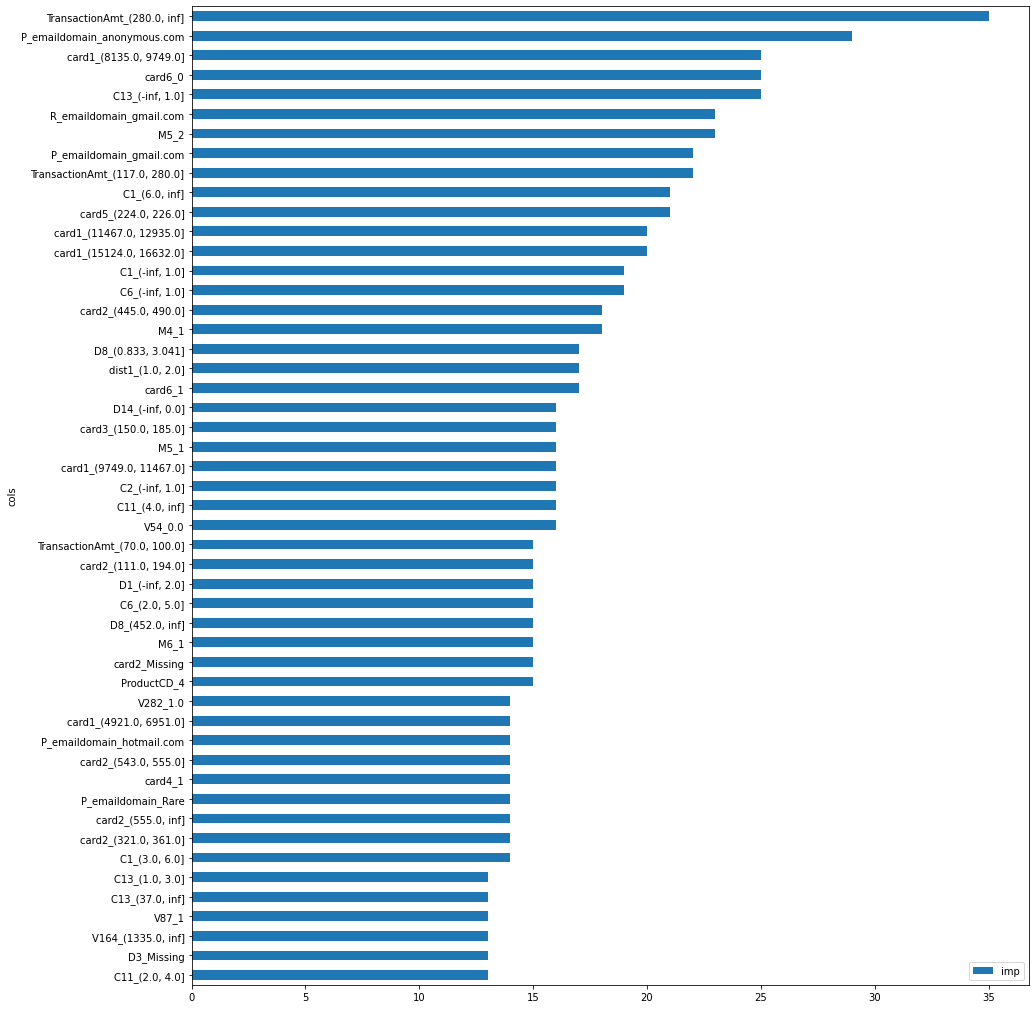

In [215]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model_n2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

#### Using Hyperopt

In [124]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import make_scorer

In [118]:

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

In [126]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

In [226]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])
        
    }
    
    clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, x_train, y_train, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)




  0%|                                   | 0/10 [00:00<?, ?trial/s, best loss=?]


Gini 0.776 params {'num_leaves': 128, 'colsample_bytree': '0.732'}             



  0%|                                   | 0/10 [03:44<?, ?trial/s, best loss=?]


 10%|▉        | 1/10 [03:44<33:38, 224.28s/trial, best loss: 0.776016089717787]


Gini 0.783 params {'num_leaves': 66, 'colsample_bytree': '0.559'}              



 10%|▉        | 1/10 [05:57<33:38, 224.28s/trial, best loss: 0.776016089717787]


 20%|█▊       | 2/10 [05:57<26:16, 197.10s/trial, best loss: 0.776016089717787]


Gini 0.783 params {'num_leaves': 64, 'colsample_bytree': '0.456'}              



 20%|█▊       | 2/10 [07:49<26:16, 197.10s/trial, best loss: 0.776016089717787]


 30%|██▋      | 3/10 [07:49<19:59, 171.37s/trial, best loss: 0.776016089717787]


Gini 0.783 params {'num_leaves': 42, 'colsample_bytree': '0.636'}              



 30%|██▋      | 3/10 [09:45<19:59, 171.37s/trial, best loss: 0.776016089717787]


 40%|███▌

In [227]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.5132404769235878, 'num_leaves': 8.0}


In [229]:
clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        colsample_bytree=  0.5132404769235878, num_leaves =8)

In [138]:
clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        colsample_bytree= 0.9677129067732777, num_leaves= 88)

In [230]:
clf.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.5132404769235878, learning_rate=0.01,
               n_estimators=500, num_leaves=8)

In [231]:
predicted = clf.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

Confusion Matrix :
[[9642   15]
 [ 262   82]]
Accuracy Score : 0.9723027697230276
Report : 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9657
           1       0.85      0.24      0.37       344

    accuracy                           0.97     10001
   macro avg       0.91      0.62      0.68     10001
weighted avg       0.97      0.97      0.96     10001



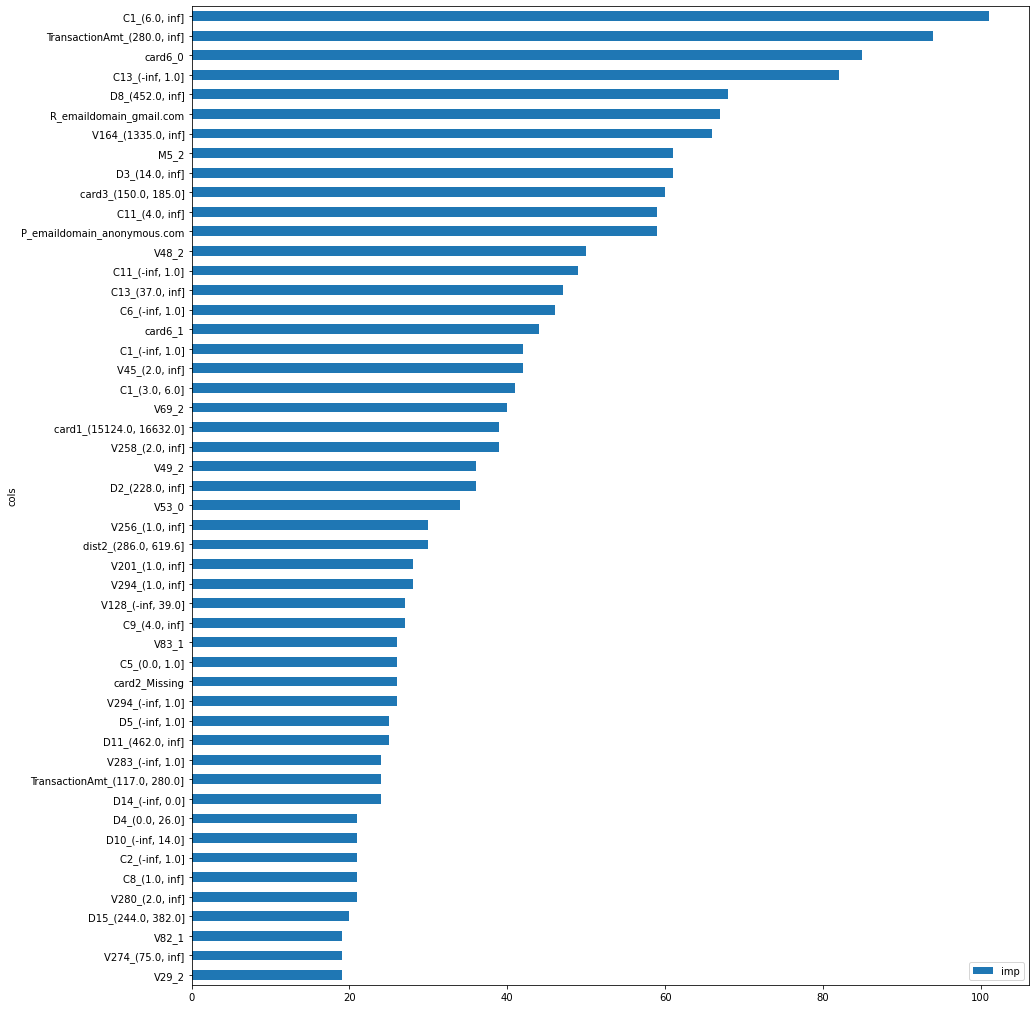

In [233]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

In [240]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'min_child_samples': int(params['min_child_samples'])
        
    }
    
    clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, x_train, y_train, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0),
    'min_child_samples': hp.quniform('min_child_samples', 8, 128, 2)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)




  0%|                                   | 0/10 [00:00<?, ?trial/s, best loss=?]


Gini 0.780 params {'num_leaves': 38, 'colsample_bytree': '0.649', 'feature_fraction': '0.761', 'min_child_samples': 20}



  0%|                                   | 0/10 [03:01<?, ?trial/s, best loss=?]


 10%|▊       | 1/10 [03:01<27:09, 181.01s/trial, best loss: 0.7800091685674673]


Gini 0.781 params {'num_leaves': 106, 'colsample_bytree': '0.956', 'feature_fraction': '0.467', 'min_child_samples': 34}



 10%|▊       | 1/10 [05:19<27:09, 181.01s/trial, best loss: 0.7800091685674673]


 20%|█▌      | 2/10 [05:19<22:26, 168.31s/trial, best loss: 0.7800091685674673]


Gini 0.775 params {'num_leaves': 120, 'colsample_bytree': '0.481', 'feature_fraction': '0.728', 'min_child_samples': 38}



 20%|█▌      | 2/10 [08:29<22:26, 168.31s/trial, best loss: 0.7800091685674673]


 30%|██▍     | 3/10 [08:29<20:23, 174.79s/trial, best loss: 0.7748602352520237]


Gini 0.754 params {'num_leaves': 12, 'colsample_bytr

In [241]:
format(best)

"{'colsample_bytree': 0.8489192082676236, 'feature_fraction': 0.8284137925636559, 'min_child_samples': 40.0, 'num_leaves': 12.0}"

In [243]:
clf2 = LGBMClassifier(
colsample_bytree= 0.8489192082676236, feature_fraction= 0.8284137925636559,
    min_child_samples= 40, num_leaves= 12)
clf2.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.8489192082676236,
               feature_fraction=0.8284137925636559, min_child_samples=40,
               num_leaves=12)

In [244]:
predicted = clf2.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

Confusion Matrix :
[[9634   23]
 [ 245   99]]
Accuracy Score : 0.9732026797320268
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9657
           1       0.81      0.29      0.42       344

    accuracy                           0.97     10001
   macro avg       0.89      0.64      0.71     10001
weighted avg       0.97      0.97      0.97     10001



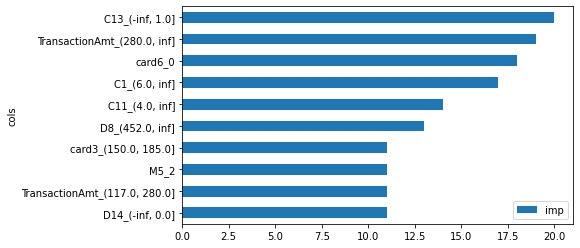

In [247]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:10]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(7,4))
plt.show()

In [257]:
clf3 = LGBMClassifier(learning_rate=0.03,
               n_estimators=500, 
colsample_bytree= 0.8489192082676236, feature_fraction= 0.8284137925636559,
    min_child_samples= 40, num_leaves= 31)
clf3.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.8489192082676236,
               feature_fraction=0.8284137925636559, learning_rate=0.03,
               min_child_samples=40, n_estimators=500)

In [258]:
predicted = clf3.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

Confusion Matrix :
[[9644   13]
 [ 227  117]]
Accuracy Score : 0.976002399760024
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9657
           1       0.90      0.34      0.49       344

    accuracy                           0.98     10001
   macro avg       0.94      0.67      0.74     10001
weighted avg       0.97      0.98      0.97     10001



In [ ]:
#### Bayesian HyperOpt

In [ ]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

space = hp.uniform('x', -5, 6)

In [ ]:
from hyperopt import tpe# Create the algorithm
tpe_algo = tpe.suggest
from hyperopt import Trials# Create a trials object
tpe_trials = Trials()

In [ ]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000)

print(tpe_best)

In [ ]:
# Dataframe of results from optimization
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

In [ ]:
import datetime
START_DATE = '2019-12-01'
X_train = pd.DataFrame()
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
x_train["Date"] = x_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
x_valid["Date"] = x_valid['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
from fast_ml.feature_engineering import FeatureEngineering_DateTime
dt_encoder = FeatureEngineering_DateTime()

#Scikit-learn type fit() transform() functionality
# Use fit() only on the train dataset
dt_encoder.fit(x_train, ['Date'], prefix = 'default')

# Use transform() on train/test dataset
x_train = dt_encoder.transform(x_train)
x_valid = dt_encoder.transform(x_valid)